# Manifold lifting: scaling Markov chain Monte Carlo to the vanishing noise regime

This [notebook](https://jupyter.org/) accompanies the paper *Manifold lifting: scaling Markov chain Monte Carlo to the vanishing noise regime* ([arXiv pre-print](https://arxiv.org/abs/2003.03950); [journal article](https://doi.org/10.1093/jrsssb/qkad023))  and illustrates applying the method described in the paper to a toy two-dimensional model using the Python packages [*Mici*](https://github.com/matt-graham/mici) and [*SymNum*](https://github.com/matt-graham/symnum).

## Set up environment

We first set up our environment by importing the Python objects we will need into the main namespace. We check if the notebook is running on [Binder](https://mybinder.org/) or [Google Colab](https://colab.research.google.com/) and set flags if so, also installing the required Python dependencies using `pip` if running on Colab (this is handled automatically by Binder using the `requirements.txt` files in the root of the [repository](https://github.com/thiery-lab/manifold_lifting).

In [1]:
import os
ON_BINDER = 'BINDER_SERVICE_HOST' in os.environ

try:
    import google.colab
    ON_COLAB = True
except ImportError:
    ON_COLAB = False

if ON_COLAB:
    !pip install mici>=0.2.1 symnum>=0.2.0 arviz>=0.16

In [2]:
import time
import inspect
from functools import partial
from itertools import product
import symnum.numpy as snp
from symnum import (
    numpify,
    named_array,
    jacobian,
    grad, 
    vector_jacobian_product,
    matrix_hessian_product
)
import numpy as np
import sympy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from ipywidgets import interact, fixed, Dropdown
from IPython.display import Javascript
import arviz
import mici
%matplotlib inline

We set some [Matplotlib](https://matplotlib.org/) styling parameters to improve the appearance of plots and seed a [NumPy](https://numpy.org/) pseudo-random number generator for reproducibility.

In [3]:
plt.rcParams.update(
    {
        "mathtext.fontset": "cm",
        "axes.titlesize": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 10,
        "axes.linewidth": 0.5,
        "lines.linewidth": 1.0,
        "axes.labelpad": 2.0,
        "figure.dpi": 100,
        "figure.figsize": (6, 6),
        "legend.frameon": False,
        "animation.html": "html5",
    }
)

dens_cmap = mcolors.LinearSegmentedColormap.from_list(
    "whiteblue",
    [
        np.array((1.000, 1.000, 1.000, 1.0)),
        np.array((0.419, 0.682, 0.840, 1.0)),
        np.array((0.031, 0.188, 0.420, 1.0)),
    ],
)

seed = 20200310
rng = np.random.default_rng(seed)

At various points in this notebook we produce plots for different values of one or more parameters to illustrate how this parameter effects the plotted quantity. If this notebook is being displayed statically (e.g. directly from Github or on NBViewer) then these plots are displayed as a grid of axes. However, when the notebook is being run interactively with an active kernel (e.g. when running on Binder, Colab or locally), then we can instead use the [`interact` function provided in `ipywidgets`](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html) to produce interactive plots that allow the parameters to be altered using slider widgets. To allow flexibility in covering both cases we define a helper function that creates either a static grid plot or an interactive plot. The plot type is changeable when an active kernel is available using a dropdown menu; you will also need to rerun the cell after changing the dropdown.

In [4]:
# To always use interactive plots by default comment the first line below
# and uncomment the second
default_plot_type = "Static" if not (ON_COLAB or ON_BINDER) else "Interactive"
# default_plot_type = 'Interactive'

plot_type = Dropdown(
    value=default_plot_type, description="Plot type", options=["Interactive", "Static"]
)


def interact_or_grid(plot_function, figsize=(12, 12), subplot_kw=None, **kwargs):
    display(plot_type)
    grid_params = kwargs.pop("grid_params", ("y", "σ"))
    params = {
        k: v[0] if plot_type.value == "Interactive" else v[1] for k, v in kwargs.items()
    }
    if plot_type.value == "Interactive":
        interact(plot_function, **params, ax=fixed(None))
    else:
        fig, axes = plt.subplots(
            len(params[grid_params[0]]),
            len(params[grid_params[1]]),
            figsize=figsize,
            subplot_kw=subplot_kw,
        )
        grid_param_0_vals = params.pop(grid_params[0])
        grid_param_1_vals = params.pop(grid_params[1])
        for (p0, p1), ax in zip(
            product(grid_param_0_vals, grid_param_1_vals), axes.flat
        ):
            plot_function(**{grid_params[0]: p0, grid_params[1]: p1}, **params, ax=ax)
            ax.set_title(rf"${grid_params[0]}={p0}, {grid_params[1]}={p1}$")
        fig.tight_layout()

## Problem statement

The problem we aim to tackle is that of inferring a latent vector $\boldsymbol{\theta} \in \Theta \subseteq \mathbb{R}^{d_{\Theta}}$ given noisy observations $\boldsymbol{y} \in \mathcal{Y} = \mathbb{R}^{d_{\mathcal{Y}}}$ generated according to a model of the form

$$\boldsymbol{y} = F(\boldsymbol{\theta}) + \sigma \boldsymbol{\eta}$$

where $F : \Theta \to \mathcal{Y}$ is the *forward function*, $\sigma > 0$ is the *observation noise standard deviation*, and $\boldsymbol{\eta} \sim \mathcal{N}(\boldsymbol{0},\mathbf{I}_{d_{\mathcal{Y}}})$ a random vector representing the additive observation noise.

We take a Bayesian approach and assume our prior beliefs about the latent vector $\boldsymbol{\theta}$ are specified by a distribution on $\Theta$ with unnormalised density $\exp(-\Phi_0(\boldsymbol{\theta}))$ with respect to the Lebesgue measure. The posterior distribution on $\Theta$ then has an (unnormalised) density $\pi^{\sigma} : \Theta \to \mathbb{R}_{\geq 0}$ defined by

$$
  -\log\pi^\sigma(\boldsymbol{\theta}) = 
  \Phi_0(\boldsymbol{\theta}) + 
  \frac{1}{2 \sigma^2} \|\boldsymbol{y} -  F(\boldsymbol{\theta})\|^2.
$$

Other than in special cases such as when the forward function $F$ is linear and the prior Gaussian, we cannot evaluate integrals with respect to the posterior distribution analytically and so instead need to use approximate inference methods to estimate posterior expectations. A particularly challenging regime for approximate inference methods, such as Markov chain Monte Carlo (MCMC) methods, is when the observation noise standard deviation $\sigma$ is small and each observation highly informative. As we will see this produces a posterior distribution with a challenging geometry for MCMC methods to efficiently explore.

## Toy two-dimensional model

As a simple example to illustrate the problem and our proposed inference approach, we use a model with $d_{\Theta} = 2$ and $d_{\mathcal{Y}} = 1$ and forward function

$$ F(\boldsymbol{\theta}) = [\theta_1^2 + 2 \theta_0^2 \, (\theta_1^2 - 0.5)].$$

We can define this forward function in Python as follows

In [5]:
dim_θ = 2
dim_y = 1


@numpify(dim_θ)
def forward_func(θ):
    return snp.array([θ[1] ** 2 + 2 * θ[0] ** 2 * (θ[0] ** 2 - 0.5)])

Here we use the `numpy` interface of the SymNum package to define the function, which will later allow us to use SymNum to automatically calculate derivatives. The `numpify` decorator generates a function which accepts and outputs NumPy arrays from the decorated function, which itself acts on symbolic array arguments. The decorator requires that we specify the dimension(s) of the array argument(s). We visualise the geometry of this forward operator by evaluating it over an equispaced grid of $\boldsymbol{\theta}$ values in $[-2, 2] \times [-2,2]$ and plotting the resulting field as a two-dimensional pseudocolour map with contours.

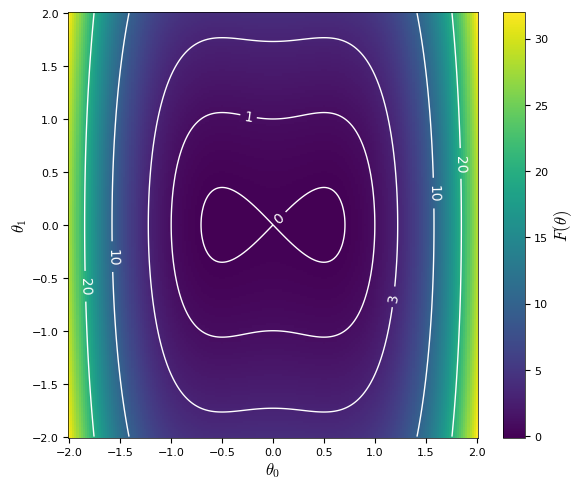

In [6]:
θ_grid = np.stack(np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201)))
f_grid = forward_func(θ_grid)
fig, ax = plt.subplots(figsize=(6, 5))
mesh = ax.pcolormesh(θ_grid[0], θ_grid[1], f_grid[0], shading="auto")
cset = ax.contour(
    θ_grid[0], θ_grid[1], f_grid[0], [-0.5, 0, 1, 3, 10, 20], colors="white"
)
ax.clabel(cset, fmt="%.2g")
cax = fig.colorbar(mesh)
_ = cax.set_label(r"$F(\mathbf{\theta})$")
_ = ax.set(xlabel=r"$\theta_0$", ylabel=r"$\theta_1$")
fig.tight_layout()

We see that the level sets of $F$ form closed curves which vary in geometry for different fixed values of $F$, forming a single closed 'loop' for $F > 0$, a [lemniscate](https://en.wikipedia.org/wiki/Lemniscate) for $F = 0$ and two disconnected closed loops for $F < 0$. As we will see shortly the varying geometry of the level sets of $F$ will be reflected in the geometry of the posterior distribution for different values of the observed $y$.

## Geometry of the posterior distribution

We assume we acquire one observation $y$ and use a standard Gaussian prior over $\boldsymbol{\theta}$, i.e. $\boldsymbol{\theta} \stackrel{\textrm{prior}}{\sim} \mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$. The goal of the inference is then to identify the set of $\boldsymbol{\theta}$ values that explain the observed $y$. Using SymNum we can define a function to evaluate the negative logarithm of the (unnormalised) posterior density, $-\log\pi^\sigma$, as follows.

In [7]:
@numpify(dim_θ, None, None)
def neg_log_posterior_dens(θ, σ, y):
    return (snp.sum(θ**2, 0) + snp.sum((y - forward_func(θ)) ** 2, 0) / σ**2) / 2

The geometry of the resulting posterior distribution depends on the values of both $y$ and $\sigma$. Below we plot the posterior density $\pi^\sigma$ across $\boldsymbol{\theta}$ values in $[-2, 2] \times [-2, 2]$ for different $y$ and $\sigma$ values.

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

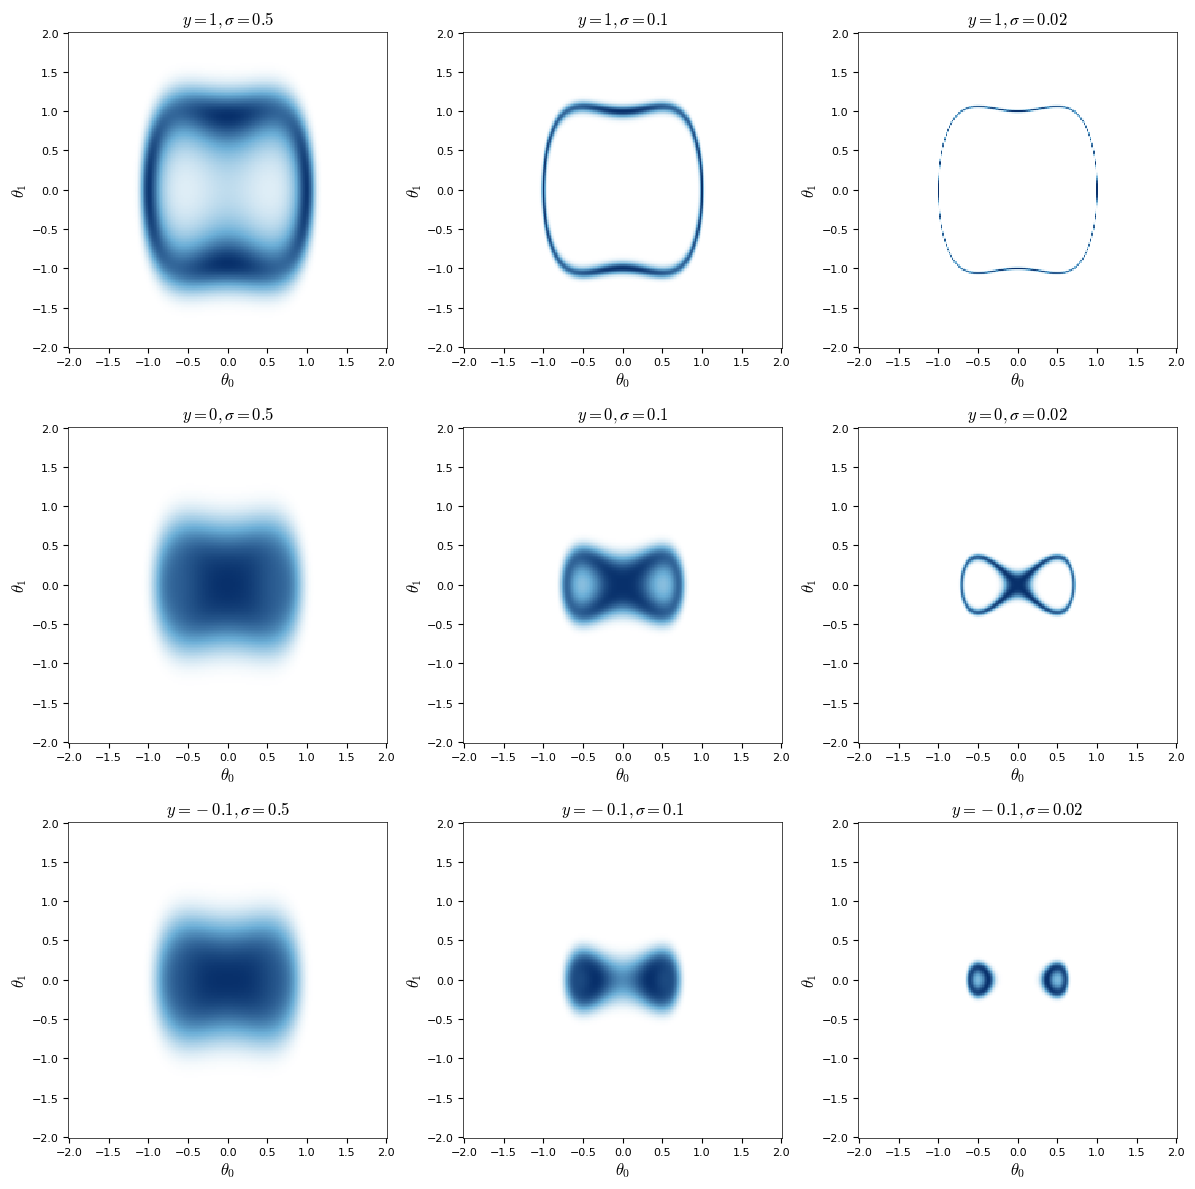

In [8]:
def create_fig_if_none(ax, **fig_kw):
    if ax is None:
        fig, ax = plt.subplots(**fig_kw)
    else:
        fig = ax.figure
    return fig, ax


def plot_posterior_density(σ=0.1, y=1.0, ax=None):
    fig, ax = create_fig_if_none(ax)
    ax.pcolormesh(
        θ_grid[0],
        θ_grid[1],
        np.exp(-neg_log_posterior_dens(θ_grid, σ, y)),
        cmap=dens_cmap,
        shading="auto",
    )
    ax.set(xlabel=r"$\theta_0$", ylabel=r"$\theta_1$")
    return fig, ax


interact_or_grid(
    plot_posterior_density,
    figsize=(12, 12),
    σ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    y=[(-0.1, 2.0, 0.1), (1, 0, -0.1)],
)

We can see that for all values of $y$ as $\sigma \rightarrow 0$, the posterior distribution concentrates on a limiting manifold $\mathcal{S}= \{\boldsymbol{\theta} : F(\boldsymbol{\theta}) = y\}$, corresponding to a specific level set of $F$. For our simple test model, we can visualise  $\mathcal{S}$ directly by explicitly solving $F(\boldsymbol{\theta}) = \boldsymbol{y}$ for $\theta_1$ in terms of $\theta_0$. This can be done using [SymPy](https://www.sympy.org/en/index.html) as in the following function (the details of how the solution is calculated are unimportant here).

In [9]:
def split_into_integer_parts(n, m):
    return [round(n / m)] * (m - 1) + [n - round(n / m) * (m - 1)]


def grid_on_interval(interval, n_points, cosine_spacing=False):
    if cosine_spacing:
        # Use non-linear spacing with higher density near endpoints
        ts = (1 + np.cos(np.linspace(0, 1, n_points) * np.pi)) / 2
    else:
        ts = np.linspace(0, 1, n_points)
    # If open interval space over range [left + eps, right - eps]
    eps = 10 * np.finfo(np.float64).eps
    left = float(interval.left) + eps if interval.left_open else float(interval.left)
    right = (
        float(interval.right) - eps if interval.right_open else float(interval.right)
    )
    return left + ts * (right - left)


def solve_for_limiting_manifold(y, n_points=200, cosine_spacing=False):
    assert n_points % 2 == 0, "n_points must be even"
    θ = named_array("θ", 2)
    # solve F(θ) = y for θ[1] in terms of θ[0]
    θ_1_gvn_θ_0 = sympy.solve(forward_func(θ)[0] - y, θ[1])
    # find interval(s) over which θ[0] gives real θ[1] solutions
    θ_0_range = sympy.solveset(θ_1_gvn_θ_0[0] ** 2 > 0, θ[0], domain=sympy.Reals)
    θ_0_intervals = (
        θ_0_range.args if isinstance(θ_0_range, sympy.Union) else [θ_0_range]
    )
    # create  grid of values over valid θ[0] interval(s)
    n_intervals = len(θ_0_intervals)
    θ_0_grids = [
        grid_on_interval(intvl, n_pt + 1, cosine_spacing)
        for intvl, n_pt in zip(
            θ_0_intervals, split_into_integer_parts(n_points // 2, n_intervals)
        )
    ]
    # generate NumPy function to calculate θ[1] in terms of θ[0]
    solve_func = sympy.lambdify(θ[0], θ_1_gvn_θ_0)
    manifold_points = []
    for θ_0_grid in θ_0_grids:
        # numerically calculate +/- θ[1] solutions over θ[0] grid
        θ_1_grid_neg, θ_1_grid_pos = solve_func(θ_0_grid)
        # stack θ[0] and θ[1] values in to 2D array in anticlockwise order
        manifold_points.append(
            np.stack(
                [
                    np.concatenate([θ_0_grid, θ_0_grid[-2:0:-1]]),
                    np.concatenate([θ_1_grid_neg, θ_1_grid_pos[-2:0:-1]]),
                ],
                -1,
            )
        )
    return manifold_points

We can verify the posterior concentrates on this limiting manifold by overlaying a plot of this manifold over the posterior density for a decreasing sequence of $\sigma$ values.

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

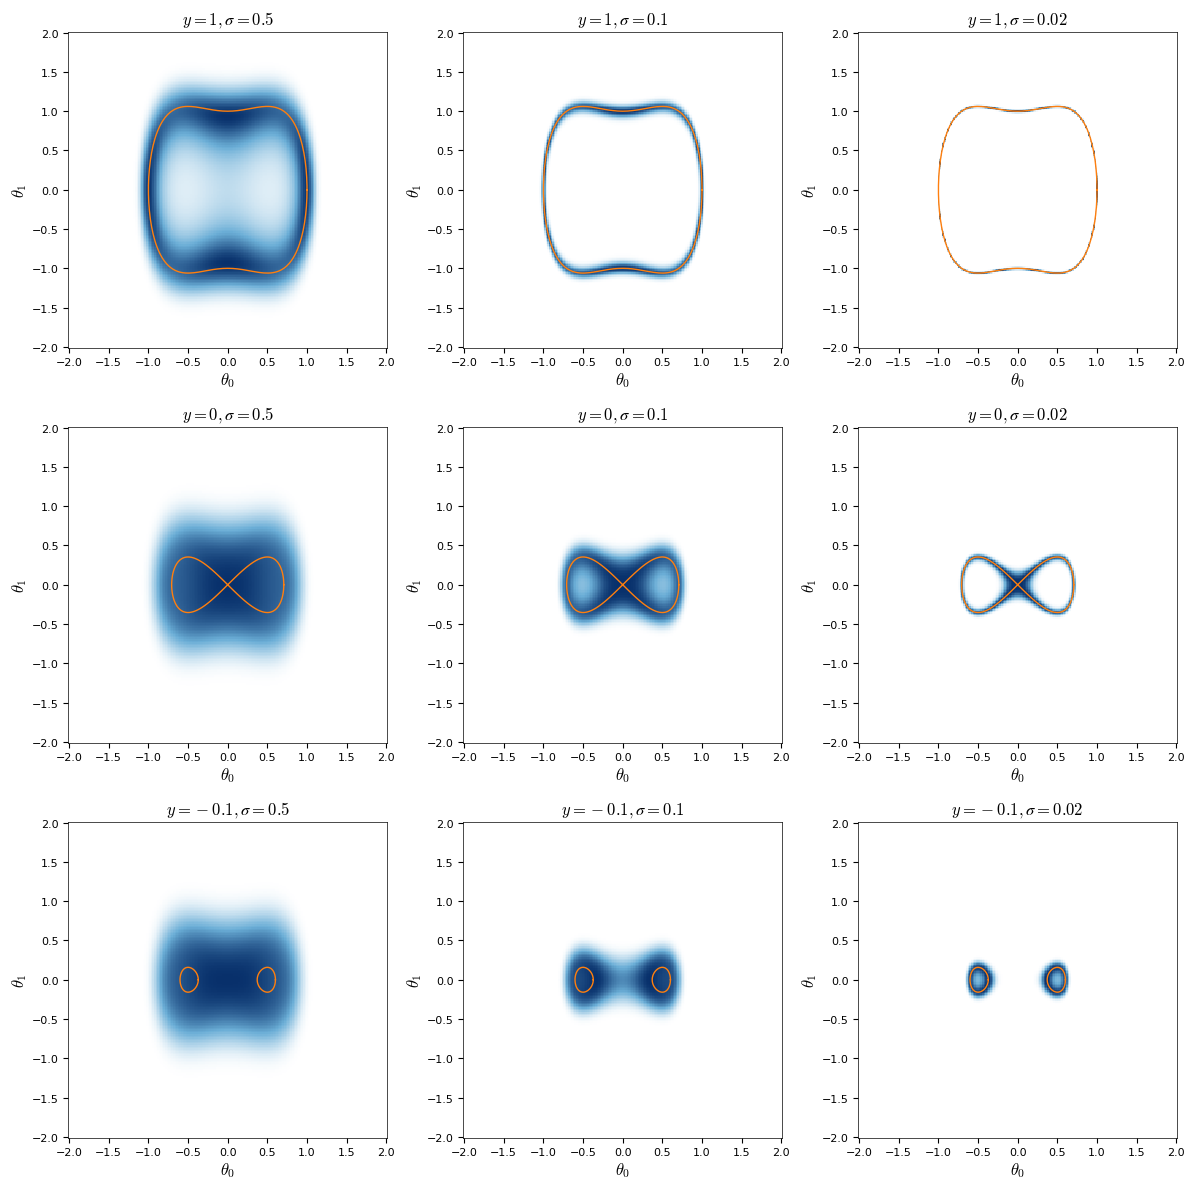

In [10]:
def plot_limiting_manifold(y, ax=None, num_points=200):
    manifold_points = solve_for_limiting_manifold(y, num_points, cosine_spacing=True)
    fig, ax = create_fig_if_none(ax)
    # repeat first point to close loop by duplicating index
    for component in manifold_points:
        indices = np.arange(component.shape[0] + 1) % component.shape[0]
        (line,) = ax.plot(
            component[indices, 0], component[indices, 1], "-", color="C1", lw=1.0
        )
    return fig, ax, line


def plot_posterior_density_and_limiting_manifold(σ=0.1, y=1, ax=None):
    fig, ax = plot_posterior_density(σ, y, ax)
    plot_limiting_manifold(y=y, ax=ax)
    return fig, ax


interact_or_grid(
    plot_posterior_density_and_limiting_manifold,
    figsize=(12, 12),
    σ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    y=[(-0.1, 2.0, 0.1), (1, 0, -0.1)],
)

The concentration of the posterior on to this lower dimensional manifold $\mathcal{S}$ makes the posterior distribution for small $\sigma$ a challenging regime for MCMC methods to operate in, with proposed moves with a non-negligible component in directions normal to the manifold having very low probability of acceptance if they start at a point in a high density region.

## Posterior density gradient field

MCMC methods often exploit derivative information to improve sampling efficiency. The simplest approach is to directly use the gradient of the log target density to guide proposed moves in the latent space $\Theta$ as in the [Metropolis adjusted Langevin algorithm (MALA)](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm) and [Hamiltonian Monte Carlo (HMC)](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo). We can construct a function to evaluate the gradient of the (negative) log posterior density using the `grad` operator from SymNum as follows.

In [11]:
grad_neg_log_posterior_dens = grad(neg_log_posterior_dens)

Using this function we can now visualise the gradient vector field across the latent space $\Theta$. Below we use the Matplotlib `quiver` plot function to overlay the (log posterior density) gradient field over the posterior density for different $\sigma$ values. As the magnitude of the gradients vary significantly we normalise the (non-zero) gradient vectors to unit length to make the pattern of the local directions of the gradients clearer.

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

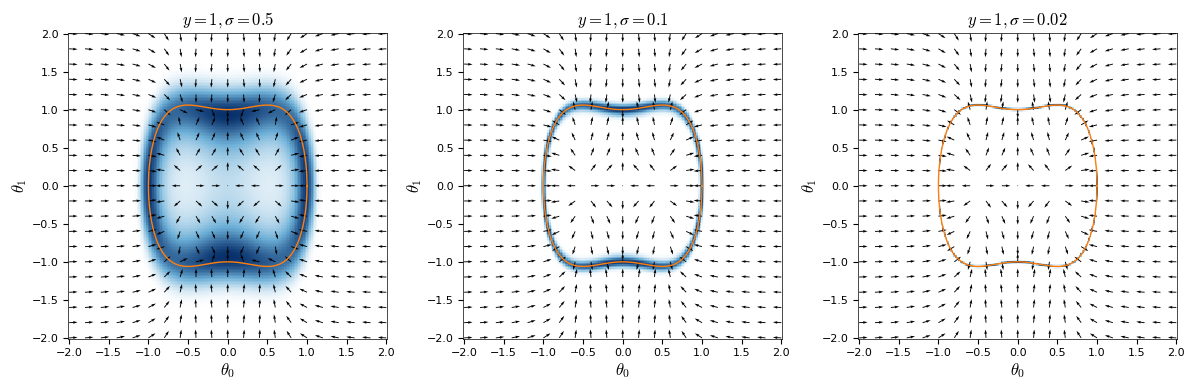

In [12]:
def plot_posterior_density_and_grad_field(σ=0.1, y=1, ax=None):
    fig, ax = plot_posterior_density_and_limiting_manifold(σ, y, ax)
    θ_grid_grad = θ_grid[:, ::10, ::10]
    grad_field = -grad_neg_log_posterior_dens(θ_grid_grad, σ, y)
    grad_field_norm = np.sum(grad_field**2, 0) ** 0.5
    grad_field[:, grad_field_norm >= 1e-8] /= grad_field_norm[grad_field_norm >= 1e-8]
    ax.quiver(*θ_grid_grad, *(grad_field), angles="xy")
    return fig, ax


interact_or_grid(
    plot_posterior_density_and_grad_field,
    figsize=(12, 4),
    σ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    y=[(-0.1, 2.0, 0.1), (1,)],
)

We can see that for points far from the bulk of the posterior mass a fictitious particle moving under the action of a force defined by the negative log density gradient field will be pushed towards the regions of high posterior density. In regions of high posterior density however, the gradient field is close to normal to the limiting manifold. For HMC proposals which are based on discretising these gradient-based dynamics with a numerical integrator, a simulated particle trajectory starting near to the high density region will be pushed in a direction normal to (and towards) the manifold by the strong gradients in that direction. The momentum of the particle will mean that it will overshoot across limiting manifold before being pushed back in the opposite direction, leading to a characteristic high frequency oscillation back and forth across the limiting manifold. If the integrator time step used to discretise the dynamics is too large the integration of this high frequency oscillation will become unstable and diverge, with the final proposed point ending up very far from the high density region and so with a vanishingly small acceptance probability. As the 'width' of the high density region around the limiting manifold and magnitude of the log density gradients scale with $\sigma$ the integrator step size needs to be made smaller as $\sigma \to 0$ to avoid this issue. 

## Hamiltonian Monte Carlo using Mici

To make the problems in choosing an appropriate step size for HMC as $\sigma \to 0$ more concrete, we now try applying HMC to our toy problem using *Mici*. Mici defines a high-level interface for construction Hamiltonian dynamics based MCMC methods, including both the standard HMC method on a Euclidean space which we will use here, and more advanced variants which involve simulating Hamiltonian dynamics on a manifold as we will see in the subsequent sections.

Mici uses a modular design to allow a wide range of MCMC methods to be constructed by using different combinations of the objects involved in sampling. The [`mici.systems`](https://matt-graham.github.io/mici/docs/systems.html) module defines various Hamiltonian system classes which are used to represent the Hamiltonian system associated with the target distribution to be sampled, and which encapsulate the various functions associated with the system. Initially we will be using the `EuclideanMetricSystem` class which corresponds to a Hamiltonian system where the latent space is equipped with a metric with a fixed positive definite matrix representation (often termed the mass matrix). By default the class uses an identity matrix for the metric representation, corresponding to the standard Euclidean metric, and we will use this default in the experiments here. 

If we denote the auxiliary momentum variable as $\boldsymbol{p} \in \mathbb{R}^{d_\Theta}$ and $U(\boldsymbol{\theta}) = -\log\pi^\sigma(\boldsymbol{\theta})$ then the Hamiltonian for the system is 

$$H(\boldsymbol{\theta},\boldsymbol{p}) = U(\boldsymbol{\theta})+ \frac{1}{2}\boldsymbol{p}^\mathsf{T}\boldsymbol{p},$$ 

and the corresponding Hamiltonian dynamics are described by the ordinary differential equation (ODE) system 

$$\dot{\boldsymbol{\theta}} = \boldsymbol{p}, \quad \dot{\boldsymbol{p}} = -\nabla U(\boldsymbol{\theta}).$$

Eliminating $\boldsymbol{p}$ by taking the time-derivative of the first equation we have that $\ddot{\boldsymbol{\theta}} = -\nabla U(\boldsymbol{\theta})$, which by comparing with Newton's second law we can see the simulated dynamics correspond to those of a particle acting under a force field defined by the negative gradient of a potential energy function $U$.

The two key arguments to the `EuclideanMetricSystem` class initialiser are `neg_log_dens` and `grad_neg_log_dens`, corresponding respectively to a function evaluating the negative log density of the target distribution $U$ and a function evaluating the gradient of this negative log density $\nabla U$. Both functions should take a single array argument, corresponding to the position component of the chain state (for now this is directly equivalent to the original latent vector $\boldsymbol{\theta}$). The `neg_log_dens` function should return a single scalar value. The `grad_neg_log_dens` function should either return a single one-dimensional array corresponding to the evaluated gradient or a 2-tuple with the first element being the gradient array and the second element a scalar corresponding to the value of `neg_log_dens` function at the passed position value. This option is provided as typically when using reverse-mode [algorithmic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) the value of a function is evaluated in the forward pass through the computational graph before evaluating the gradient in a backwards pass, and by returning both the gradient and value and caching the value, Mici can avoid subsequent separate evaluation of the `neg_log_dens` function.

The SymNum `grad` operator provides an option to also return the value of the function by passing the `return_aux=True` keyword argument.

In [13]:
grad_and_val_neg_log_posterior_dens = grad(neg_log_posterior_dens, return_aux=True)

We now construct a `EuclideanMetricSystem` instance using the `neg_log_posterior_dens` and `grad_and_val_neg_log_posterior_dens` functions. To meet the requirement of the `neg_log_dens` and `grad_neg_log_dens` function arguments accepting only a single array argument, we use the `functools.partial` function to produce a [partial function](https://en.wikipedia.org/wiki/Partial_application) with the arguments `σ` and `y` and fixed.

In [14]:
σ = 0.1
y = 1

system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
    grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y),
)

As mentioned previously system objects in Mici encapsulate various model specific functions such as the Hamiltonian and its derivatives. Below we print all the 'public' attributes (i.e. those not prefixed with an underscore) of the system object we just created and the first line of their docstrings.

In [15]:
def print_attributes(obj):
    for attr in dir(obj):
        if attr[0] != "_":
            print(f"{attr}: {inspect.getdoc(getattr(obj, attr)).splitlines()[0]}")


print_attributes(system)

dh1_dpos: Derivative of `h1` Hamiltonian component with respect to position.
dh2_dmom: Derivative of `h2` Hamiltonian component with respect to momentum.
dh2_dpos: Derivative of `h2` Hamiltonian component with respect to position.
dh_dmom: Derivative of Hamiltonian with respect to momentum.
dh_dpos: Derivative of Hamiltonian with respect to position.
grad_neg_log_dens: Derivative of negative log density with respect to position.
h: Hamiltonian function for system.
h1: Hamiltonian component depending only on position.
h1_flow: Apply exact flow map corresponding to `h1` Hamiltonian component.
h2: Hamiltonian component depending on momentum and optionally position.
h2_flow: Apply exact flow map corresponding to `h2` Hamiltonian component.
metric: Matrix representing identity operator on a vector space.
neg_log_dens: Negative logarithm of unnormalized density of target distribution.
sample_momentum: Sample a momentum from its conditional distribution given a position.


Most of the system methods listed above take a `mici.states.ChainState` instance as their first (or only) argument. A `ChainState` object in Mici encapsulates the current state of a Hamiltonian system which is minimally specified by a position (`pos`, a 1D array), momentum (`mom`, a 1D array) and integration 'direction' (`dir`, either +1 or -1) corresponding to whether the Hamiltonian dynamics are currently being simulated forward (`dir=1`) or backwards (`dir=-1`) in time. In addition to these variables, a `ChainState` instance may also contain cached values of quantities deterministically derived from these variables by a Hamiltonian system object - for example the current Hamiltonian value or its derivatives. By caching these values Mici ensures potentially expensive to evaluate functions are only evaluate once for each value of the state variables they depend on.

In the cell below we construct a `ChainState` instance with the position component (here corresponding to $\boldsymbol{\theta}$) sampled from the standard normal prior on $\Theta$. Rather than set the momentum in the chain state initialiser we use the `system.sample_momentum` method to independently sample a momentum from its conditional distribution given the position; although in this case as the momentum is independent of the position and has a standard normal distribution we could easily sample the momentum directly, for some of the systems we will encounter subsequently the momentum distribution will be position-dependent and so this approach is more general.

In [16]:
state = mici.states.ChainState(pos=rng.standard_normal(dim_θ), mom=None, dir=1)
state.mom = system.sample_momentum(state, rng)

In addition to the `system` and `state` objects, another key class of Mici objects are the integrator classes in the [`mici.integrators`](https://matt-graham.github.io/mici/docs/integrators.html) module. For the simple `EuclideanMetricSystem` we are using here, the `LeapfrogIntegrator` is an appropriate choice of integrator, for this system corresponding to the standard [Störmer-Verlet or leapfrog integrator](https://en.wikipedia.org/wiki/Leapfrog_integration) for [separable Hamiltonian systems](https://en.wikipedia.org/wiki/Symplectic_integrator#Splitting_methods_for_separable_Hamiltonians). The `LeapfrogIntegrator` initialiser takes as arguments a Hamiltonian system instance and a floating point `step_size` parameter corresponding to the time-step used in the numerical discretisation of the Hamiltonian dynamics. 

In [17]:
integrator = mici.integrators.LeapfrogIntegrator(system, step_size=0.05)

The key method of integrator objects is the `integrator.step` method which takes as argument a `ChainState` instance and returns a new `ChainState` instance corresponding to the system state simulated one time-step forward (if `state.dir = 1`) or backward (if `state.dir = -1`) in time under the Hamiltonian dynamics associated with the system. Below we iteratively apply `integrator.step` twice before reversing the integration direction and integrating a further two steps. The state returns to the exactly the same position and momentum values due to the time-reversibility of the leapfrog integrator.

In [18]:
n_step = 2
state_init = state.copy()
display(state)
for s in range(n_step):
    state = integrator.step(state)
    display(state)
state.dir *= -1
display(state)
for s in range(n_step):
    state = integrator.step(state)
    display(state)
state.dir *= -1
assert np.allclose(state.pos, state_init.pos) and np.allclose(state.mom, state_init.mom)

ChainState(
 pos=[-0.329414   -1.46108452],
 mom=[-0.98537164  0.25382918],
 dir=1)

ChainState(
 pos=[-0.42719971 -1.06310332],
 mom=[-1.95328196  8.06222033],
 dir=1)

ChainState(
 pos=[-0.5247422  -0.65486249],
 mom=[-2.12262924  5.90596858],
 dir=1)

ChainState(
 pos=[-0.5247422  -0.65486249],
 mom=[-2.12262924  5.90596858],
 dir=-1)

ChainState(
 pos=[-0.42719971 -1.06310332],
 mom=[-1.95328196  8.06222033],
 dir=-1)

ChainState(
 pos=[-0.329414   -1.46108452],
 mom=[-0.98537164  0.25382918],
 dir=-1)

The final key group of Mici objects are the sampler classes in the [`mici.samplers`](https://matt-graham.github.io/mici/docs/samplers.html) module. A sampler object uses a Hamiltonian system and associated integrator to simulate Markov chains which leave the target distribution represented by the system invariant. The simplest sampler is the `StaticMetropolisHMC` class which corresponds to the Hybrid Monte Carlo algorithm proposed by [Duane, Kennedy, Pendleton and Roweth (1987)](https://doi.org/10.1016%2F0370-2693%2887%2991197-X): each new state is proposed by integrating the dynamic forward a fixed number of steps and accepting or rejecting the move from the initial to final state on the trajectory in a Metropolis accept step. These 'integration' chain transitions in which the position and momentum components are jointly updated are alternated with transitions in which only the momentum is updated, with the default being to independently resample the momentum from its conditional distribution given the current position. 

In addition to the `StaticMetropolisHMC` class, Mici also provides other sampler classes such as the `RandomMetropolisHMC` class which instead integrates the state a randomly sampled rather than fixed number of steps in each integration transition, and the `DynamicMultinomialHMC` class which uses [a heuristic 'no-U-turn' criterion to dynamically determine how many integration steps to take](http://jmlr.org//papers/v15/hoffman14a.html) (and uses a [multinomial scheme to sample the new state from the whole recursively generated trajectory](https://arxiv.org/abs/1701.02434)). As an example we construct a `StaticMetropolicHMC` sampler by passing the previously created `system`, `integrator` and `rng` (random number generator) objects as arguments to the class initialiser and setting the fixed number of integration steps to `n_step=20`.

In [19]:
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=20)

The two key method of a `sampler` object is `sample_chains` which samples one or more Markov chains from a list of initial states. The `sample_chains` method returns a tuple of three objects:

  * `final_states`: State(s) of chain after final iteration. May be used to resume sampling a chain by passing as the initial state to a new `sample_chains` call.
  * `traces`: Dictionary of chain traces. Values in dictionary are lists of arrays of variables, one array per chain, outputted by trace functions in `trace_funcs` argument to `sample_chains` with leading dimension of array corresponding to the sampling (chain iteration) index. By default `trace_funcs` consists of a single function returning the position component of the state and Hamiltonian and so `traces` contains two entries with keys `pos` and `hamiltonian`.
  * `statistics`: Dictionary of chain statistics. Values in dictionary are lists of arrays of chain statistic values, one array per chain, with the leading dimension of each array corresponding to the sampling (chain iteration) index. The key for each value is a string description of the corresponding statistic - for example the per-iteration acceptance probability statistics are stored under the key `accept_stat`.


As well as an `init_states` argument specifying the initial chain states (either as a list of `ChainState` instances or 1D NumPy arrays specifying only the position component with the momentum component then sampled independently using `system.sample_momentum`) the other required arguments to the `sample_chains` method are `n_warm_up_iter` and `n_main_iter`, the number of chain iterations in the initial adaptive warm-up phase and main sampling stage respectively. Below we call `sample_chains` to sample a single chain of 2000 main iterations (and no warm-up iterations) starting from the chain state `state` constructed previously. During sampling by default Mici displays a progress bar showing how many chain iterations have been completed so far, the expected time to completion and running averages of chain statistics such as the acceptance probability of Metropolis transitions (the statistics to be monitored can be altered by setting the `monitor_stats` argument to `sample_chains`, see docstring for details).

In [20]:
final_state, traces, stats = sampler.sample_chains(
    n_warm_up_iter=0, n_main_iter=2000, init_states=[state]
)

Sampling stage: Main non-adaptive [00:01]

Chain 1/1: 100%|██████████|2000/2000 [00:01<00:00, 1197.83it/s, accept_stat=0.605]

<string>:9: RuntimeWarning: overflow encountered in scalar multiply
<string>:10: RuntimeWarning: overflow encountered in scalar power
/home/matt/projects/mici/src/mici/systems.py:145: RuntimeWarning: invalid value encountered in subtract
  state.mom -= dt * self.dh1_dpos(state)
<string>:6: RuntimeWarning: overflow encountered in scalar multiply
<string>:2: RuntimeWarning: overflow encountered in scalar power
<string>:5: RuntimeWarning: overflow encountered in scalar power
/home/matt/projects/mici/src/mici/systems.py:334: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)
<string>:10: RuntimeWarning: overflow encountered in scalar multiply
<string>:3: RuntimeWarning: overflow encountered in scalar multiply


We see that a series of numerical warnings are produced - specifically due to numerical overflow and invalid ([NaN](https://en.wikipedia.org/wiki/NaN)) values being encountered in some operations. These warnings are useful inasmuch that they indicate there is some numerical issue being encountered while sampling - specifically as we will see shortly that the numerical integration of the Hamiltonian dynamics is unstable at the step size being used - however for long chains the flood of warning messages can be annoying so we instruct NumPy to ignore these warnings subsequently.

In [21]:
_ = np.seterr(invalid="ignore", over="ignore")

If we plot the trace of the position component of the chain state over the corresponding target posterior density we see further evidence that the HMC sampler is not performing well here as the samples are concentrated in only one portion of the loop-like region of high posterior probability, with in particular the chain seeming to have been unable to enter the two narrower 'legs' of the loop.

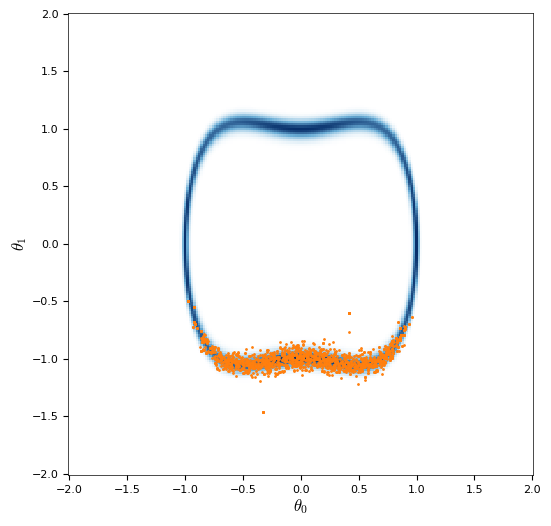

In [22]:
fig, ax = plot_posterior_density(σ=σ, y=y)
ax.plot(*traces["pos"][0].T, ".", ms=2, color="C1")

While the sampler classes are the intended interface for generating chains in Mici, for the purpose of understanding the issues being encountered in running HMC in our illustrative example, we will directly use an integrator object to simulate and plot the Hamiltonian trajectories being used to propose new states in the HMC chain. The function `simulate_proposal` in the cell below implements a basic Metropolis-adjusted HMC algorithm with a fixed number of integration steps `n_step` per proposal (i.e. equivalent to the transitions implemented by the `StaticMetropolisHMC` sampler class). Rather than return just the next chain state (either the final state in the simulated trajectory if the move is accepted or the previous state if rejected) the `simulate_proposal` function here returns the full simulated trajectory and a boolean flag indicating whether the proposed move was accepted, so as to allow the proposal to be visualised. As well as rejecting due to the Metropolis accept step, in the implementation below rejections may also be triggered if the integrator diverges. This is indicated by the change in Hamiltonian over the trajectory (which should be zero under the exact dynamics) exceeding a threshold, in which case the trajectory is terminated early. In the manifold MCMC methods discussed later rejections may also be triggered by divergence of the numerical solvers involved in computing the individual (implicit) integrator steps, with this resulting in the same behaviour of terminating the trajectory early and rejecting the proposal.

In [23]:
def simulate_proposal(state, system, integrator, rng, n_step=10):
    state.mom = system.sample_momentum(state, rng)
    θ_traj = np.full((n_step + 1, dim_θ), np.nan)
    θ_traj[0] = state.pos[:dim_θ]
    h_init = system.h(state)
    try:
        for s in range(n_step):
            state = integrator.step(state)
            if abs(system.h(state) - h_init) > 1000:
                raise mici.errors.HamiltonianDivergenceError
            θ_traj[s + 1] = state.pos[:dim_θ]
        accepted = rng.uniform() < np.exp(h_init - system.h(state))
    except mici.errors.Error as e:
        accepted = False
    return θ_traj, accepted

We also define a helper function to plot a proposed trajectory, with the initial state shown by a larger marker and the trajectory coloured green if accepted and red if not.

In [24]:
def plot_trajectory(ax, θ_traj, accepted):
    ax.plot(
        θ_traj[:, 0],
        θ_traj[:, 1],
        "-o",
        ms=2,
        lw=1,
        color=("limegreen" if accepted else "red"),
    )
    ax.plot(θ_traj[0, 0], θ_traj[0, 1], "o", color=("limegreen" if accepted else "red"))

Using the two helper functions we just defined, we now plot simulated HMC proposals for various values of the noise standard deviation $\sigma$ and integrator step size $\epsilon$ on our running toy example. The proposals are initialised at series of points on the limiting manifold $\mathcal{S}$ and so are reflective of proposals for chains which have already converged to the high probability region of the target posterior distribution.

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

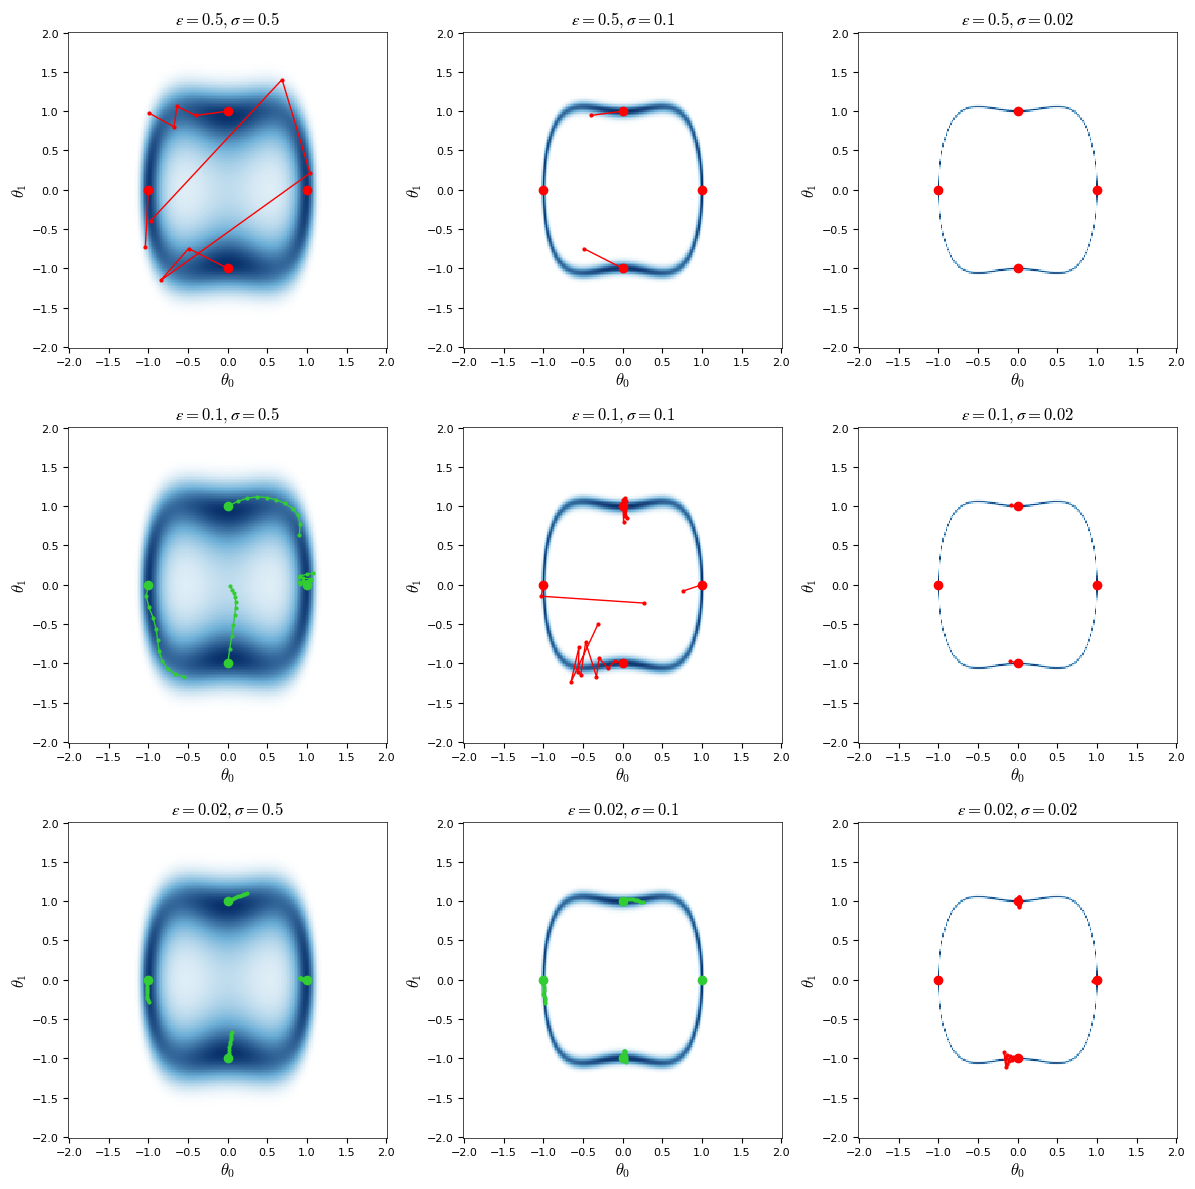

In [25]:
def plot_hmc_proposals(σ=0.1, ϵ=0.1, y=1, n_step=20, n_particle=4, ax=None):
    system = mici.systems.EuclideanMetricSystem(
        neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
        grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y),
    )
    integrator = mici.integrators.LeapfrogIntegrator(system, step_size=ϵ)
    states = [
        mici.states.ChainState(pos=θ, mom=None, dir=1)
        for θ in np.concatenate(solve_for_limiting_manifold(y, n_particle))
    ]
    fig, ax = plot_posterior_density(σ, y, ax)
    rng = np.random.default_rng(seed)
    for state in states:
        plot_trajectory(ax, *simulate_proposal(state, system, integrator, rng, n_step))


interact_or_grid(
    plot_hmc_proposals,
    σ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    ϵ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    y=[(-0.1, 2.0), y],
    n_step=[(10, 100, 10), 10],
    n_particle=[(4, 10, 2), 4],
    grid_params=("ε", "σ"),
)

We see that for the smallest $\sigma=0.02$ value the Hamiltonian trajectories quickly diverge (indicated by only the initial point or the initial points plus a few other points being plotted) and result in a rejection even for the smallest integrator step size shown $\epsilon = 0.02$. From the portions of the diverging trajectories which are visible we can clearly see the overshooting effect due to the large gradient components normal to the limiting manifold discussed earlier, with the trajectories showing a characteristic oscillation with rapidly increasing amplitude back and forth across the the region of high posterior density. For a more moderate $\sigma = 0.1$ value, the smallest step size $\epsilon = 0.02$ leads to trajectories which do not diverge and result in an accepted proposal in some parts of the latent space (specifically in the 'wider' top and bottom portions of the loop) but still lead to divergences and rejections in others. Only for the largest $\sigma$ values is it possible to find an integrator step size (in the range available) that results in stable integration at all points tested. In general it is clear that to maintain a reasonable probability of acceptance as $\sigma \to 0$ the integrator step size $\epsilon$ also needs to be reduced towards zero. 

To more precisely characterise how the integrator step size $\epsilon$ needs to be scaled with $\sigma$ to maintain a non-vanishing acceptance rate, the code in the cell below performs a grid search over a logarithmically spaced range of $\sigma$ and $\epsilon$ values to compute the average acceptance probability for short HMC chains on our running toy example. For each $(\sigma, \epsilon)$ pair, Mici is used to run four chains of 20 samples, initialised at points on the limiting manifold $\mathcal{S}$, with a fixed 20 integrator steps per proposal, with the average Metropolis acceptance probability across all chains recorded. As many short chains are being run, the per-chain progress bars that would usually be displayed by Mici are disabled and instead a progress bar is used to track progress across all the different $(\sigma, \epsilon)$ pairs.

In [26]:
n_sample = 20
n_chain = 4
n_step = 20

σ_grid = np.logspace(-5, 0, 11)
ϵ_grid = np.logspace(-5, 0, 11)

θ_inits = np.concatenate(solve_for_limiting_manifold(y, n_chain))

hmc_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), np.nan)

with mici.progressbars.SequenceProgressBar(
    list(enumerate(product(σ_grid, ϵ_grid))), "Completed"
) as pb:
    for (i, (σ, ϵ)), _ in pb:
        system = mici.systems.EuclideanMetricSystem(
            neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
            grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y),
        )
        integrator = mici.integrators.LeapfrogIntegrator(system, step_size=ϵ)
        sampler = mici.samplers.StaticMetropolisHMC(
            system, integrator, rng, n_step=n_step
        )
        _, _, stats = sampler.sample_chains(
            n_warm_up_iter=0,
            n_main_iter=n_sample,
            init_states=θ_inits,
            display_progress=False,
        )
        hmc_av_accept_probs.flat[i] = np.concatenate(
            [a for a in stats["accept_stat"]]
        ).mean()

Completed: 100%|██████████|121/121 [00:06<00:00, 18.56it/s]

We now visualise the results from the above grid search across $\sigma$ and $\epsilon$ values as a pseudocolor plot (heatmap) with brighter colours indicating higher average acceptance probabilities.

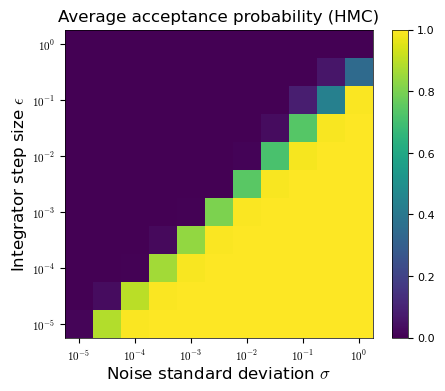

In [27]:
def plot_statistic_heatmap(
    σ_grid, ϵ_grid, statistic_grid, ax=None, title=None, colorbar=True
):
    fig, ax = create_fig_if_none(ax, figsize=(5, 4))
    artist = ax.imshow(statistic_grid.T, vmin=0, vmax=1, origin="lower")
    ax.set(
        xlabel="Noise standard deviation $\sigma$",
        ylabel="Integrator step size $\epsilon$",
        title=title,
        aspect=1,
        xticks=np.arange(σ_grid.shape[0])[::2],
        xticklabels=[f"$10^{{{int(i)}}}$" for i in np.log10(σ_grid[::2])],
        yticks=np.arange(ϵ_grid.shape[0])[::2],
        yticklabels=[f"$10^{{{int(i)}}}$" for i in np.log10(ϵ_grid[::2])],
    )
    if colorbar:
        fig.colorbar(artist, ax=fig.axes)
    return fig, ax


fig, ax = plot_statistic_heatmap(
    σ_grid, ϵ_grid, hmc_av_accept_probs, title="Average acceptance probability (HMC)"
)

We can clearly see that we require $\epsilon \propto \sigma$ for HMC to maintain a non-zero acceptance rate, with in particular we needing $\epsilon \lessapprox 0.3 \sigma$ for a reasonable acceptance probability. As the distance traversed by a simulated trajectory will scale roughly proportionally to $\epsilon$ this will mean that as $\sigma$ becomes small we need to use an increasing number of integrator steps and so computational effort to achieve approximately independent Markov chain samples.

## Riemannian-manifold Hamiltonian Monte Carlo

The issues encountered when applying HMC to our problem when $\sigma$ is small can be attributed at a high level to the anisotropic scaling of the posterior distribution across the latent space, with the posterior much more tightly 'constrained' in directions normal to the limiting manifold $\mathcal{S}$ than tangential to it. Importantly as the limiting manifold is non-linear these normal and tangential directions vary across the space and so a simple global preconditioning by reparameterising in terms of a linear transformation of the latent variables (or equivalently using a fixed non-identity metric matrix representation) will not be able to resolve the problems encountered.

The problem of devising efficient MCMC methods for distributions with varying scales at different points and along different directions in space has been the motivation for several previously suggested algorithms. Of particular interest here are [*Riemannian-manifold Langevin and Hamiltonian Monte Carlo methods*](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2010.00765.x) (Girolami and Calderhead, 2011), which extends the standard HMC approach to the case where the latent space is treated as a [Riemannian manifold](https://en.wikipedia.org/wiki/Riemannian_manifold) and equipped with a position-dependent metric, represented by a matrix valued function $\mathbf{M} : \Theta \to \mathcal{P}^{d_\Theta}_{+}$ where $\mathcal{P}^{d_\Theta}_{+}$ is the set of $d_\Theta \times d_\Theta$ symmetric positive-definite matrices with real entries. The metric locally defines geometric quantities such as the length of and angle between vectors, and also allows computation of the distance between points on the manifold. An appropriate choice of metric which accounts for the locally varying geometry of the posterior distribution can therefore be used to counteract the issues encountered when running HMC on the latent space equipped with a Euclidean metric.

Girolami and Calderhead (2011) suggest using a metric based on the [Fisher information metric](https://en.wikipedia.org/wiki/Fisher_information_metric)

$$
  [\mathbf{G}(\boldsymbol{\theta})]_{i,j} = \int_{\mathcal{Y}} \nabla_i \ell_{\boldsymbol{y}}(\boldsymbol{\theta}) \nabla_j \ell_{\boldsymbol{y}}(\boldsymbol{\theta}) \exp(-\ell_{\boldsymbol{y}}(\boldsymbol{\theta})) \,\mathrm{d}\boldsymbol{y}
$$

where $\ell_{\boldsymbol{y}}(\boldsymbol{\theta})$ is the negative log-likelihood of $\boldsymbol{\theta}$ given data $\boldsymbol{y}$. For our Gaussian observation noise model the Fisher information metric corresponds to $\mathbf{G}(\boldsymbol{\theta}) = \frac{1}{\sigma^2}\mathbf{D} F(\boldsymbol{\theta})^{\mathsf{T}} \mathbf{D} F(\boldsymbol{\theta})$ where $\mathbf{D} F: \Theta \to \mathbb{R}^{d_{\mathcal{Y}}\times d_{\Theta}}$ is the Jacobian of the forward function $F$. The Fisher information metric is not guaranteed to be strictly positive definite and Girolami and Calderhead (2011) suggesting adding the Hessian of the negative log prior density to the metric matrix representation; for our toy model with a standard normal prior this gives a metric matrix function

$$\mathbf{M}(\boldsymbol{\theta}) = \frac{1}{\sigma^2}\mathbf{D} F(\boldsymbol{\theta})^{\mathsf{T}} \mathbf{D} F(\boldsymbol{\theta}) + \mathbf{I}_{d_{\Theta}}.$$

We can define a function to evaluate this metric matrix representation at a point $\boldsymbol{\theta}$ by using the SymNum `jacobian` operator to automatically compute the Jacobian of the forward function.

In [28]:
@numpify(dim_θ, None)
def metric(θ, σ):
    jac = jacobian(forward_func)(θ)
    return jac.T @ jac / σ**2 + snp.identity(dim_θ)

The Hamiltonian for the resulting Riemannian-manifold system is 

$$H(\boldsymbol{\theta},\boldsymbol{p}) = U(\boldsymbol{\theta}) + \frac{1}{2}\log|\mathbf{M}(\boldsymbol{\theta})| + \frac{1}{2}\boldsymbol{p}^{\mathsf{T}}\mathbf{M}(\boldsymbol{\theta})^{-1} \boldsymbol{p},$$ 

and the associated Hamiltonian dynamics are described by the ODE system 

$$
   \dot{\boldsymbol{\theta}} = \nabla_2 H(\boldsymbol{\theta},\boldsymbol{p}) = 
   \mathbf{M}(\boldsymbol{\theta})^{-1} \boldsymbol{p}, \quad
   \dot{\boldsymbol{p}} = -\nabla_1 H(\boldsymbol{\theta},\boldsymbol{p}) = 
   -\nabla U(\boldsymbol{\theta})
   -\frac{1}{2} \mathsf{VJP}(\mathbf{M})(\boldsymbol{\theta})\big(\mathbf{M}(\boldsymbol{\theta})^{-1}\big)^{\mathsf{T}} 
   +\frac{1}{2} \mathsf{VJP}(\mathbf{M})(\boldsymbol{\theta})\big(\mathbf{M}(\boldsymbol{\theta})^{-1}\boldsymbol{p} \boldsymbol{p}^{\mathsf{T}}  \mathbf{M}(\boldsymbol{\theta})^{-1}\big)^\mathsf{T}.
$$

Here $\mathsf{VJP}$ indicates a ['vector-Jacobian-product' differential operator](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#Vector-Jacobian-products-(VJPs,-aka-reverse-mode-autodiff)), corresponding to a generalisation of the operation of computing the product $\boldsymbol{v}^\mathsf{T}\mathbf{D}\boldsymbol{f}(\boldsymbol{x})$ between a vector $\boldsymbol{v} \in \mathbb{R}^N$ and the $N \times M$ Jacobian matrix of a map $\boldsymbol{f}: \mathbb{R}^M\to\mathbb{R}^N$. For a map $\boldsymbol{f} : \mathbb{R}^M \to \mathbb{R}^{N_1 \times N_2 \dots \times N_D}$, $\boldsymbol{v} \in \mathbb{R}^{N_1 \times N_2 \dots \times N_D}$ and 'vectorisation' operator $\mathrm{vech}$ that flattens an arbitrary dimensioned array to a flat vector we have that

$$
  \mathsf{VJP}(\boldsymbol{f})(\boldsymbol{x})(\boldsymbol{v}) = \mathrm{vech}(\boldsymbol{v})^{\mathsf{T}} \mathbf{D} (\mathrm{vech}\circ \boldsymbol{f})(\boldsymbol{x}).
$$

We can construct an operator evaluating $\mathsf{VJP}(\mathbf{M})$ in SymNum by applying the `vector_jacobian_product` operator to the `metric` function defined previously. As with the `grad` operator, `vector_jacobian_product` takes an optional keyword argument `return_aux` which we set to `True` to indicate the returned function should return both a function to evaluate the vector Jacobian product at point but also the value of the function (here the metric).

In [29]:
vjp_metric = vector_jacobian_product(metric, return_aux=True)

As we did for the Euclidean metric Hamiltonian dynamic, we can eliminate the momentum variables from the ODE system to get the following second-order differential equation system

$$
  \ddot{\boldsymbol{\theta}} =
  \color{blue}{{}
    -\mathbf{M}(\boldsymbol{\theta})^{-1}\nabla U(\boldsymbol{\theta})
  }
  \color{green}{{}
    -\frac{1}{2} \mathbf{M}(\boldsymbol{\theta})^{-1} \mathsf{VJP}(\mathbf{M})(\boldsymbol{\theta})(\mathbf{M}(\boldsymbol{\theta})^{-1})^{\mathsf{T}}
  }
  \color{red}{{}
    -\frac{1}{2} \mathbf{M}(\boldsymbol{\theta})^{-1} \Big(
    2\mathsf{JVP}(\mathbf{M})(\boldsymbol{\theta})(\dot{\boldsymbol{\theta}}) \dot{\boldsymbol{\theta}} -
    \mathsf{VJP}(\mathbf{M})(\boldsymbol{\theta})(\dot{\boldsymbol{\theta}} \dot{\boldsymbol{\theta}}{}^\mathsf{T})^\mathsf{T}
  \Big)}.
$$

Here $\mathsf{JVP}$ indicates a ['Jacobian-vector-product' differential operator](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#Jacobian-Vector-products-(JVPs,-aka-forward-mode-autodiff)) which, analogously to the $\mathsf{VJP}$ operator, is defined as a generalisation of the operation of computing the product $\mathbf{D}\boldsymbol{f}(\boldsymbol{x})\boldsymbol{v}$ between the Jacobian matrix of a map $\boldsymbol{f}: \mathbb{R}^M\to\mathbb{R}^N$ and a vector $\boldsymbol{v} \in \mathbb{R}^M$. For a real-valued function $f$ on a Riemannian manifold the [*Riemannian gradient*](https://en.wikipedia.org/wiki/Gradient#Riemannian_manifolds) $\mathrm{grad}$ can be defined in local coordinates in terms of the inverse of the metric matrix representation and vector of partial derivatives $\nabla f(\boldsymbol{\theta}) = [\partial_0 f(\boldsymbol{\theta}) ~ \cdots ~ \partial_{d_\Theta-1} f(\boldsymbol{\theta})]^{\mathsf{T}}$ as

$$\mathrm{grad} f(\boldsymbol{\theta}) = \mathbf{M}^{-1}(\boldsymbol{\theta}) \nabla f(\boldsymbol{\theta}).$$

The blue and green terms above therefore correspond to the Riemannian gradient of respectively the potential energy (negative log target density) and log-determinant of the metric (with the metric determinant representing the density of the [Riemannian measure or volume form](https://en.wikipedia.org/wiki/Volume_form#Riemannian_volume_form) on the manifold with respect to the Lebesgue measure on the coordinate space). If only the term in red was included the dynamics would correspond to the [geodesic equation](https://en.wikipedia.org/wiki/Solving_the_geodesic_equations) on the manifold, i.e. the differential equation system defining [geodesics](https://en.wikipedia.org/wiki/Geodesic) on the manifold and corresponding to the motion of a particle with no [proper acceleration](https://en.wikipedia.org/wiki/Proper_acceleration) on the manifold. The dynamics can therefore be interpreted as corresponding to the motion of a particle on the manifold subject to a force field defined by the Riemannian gradient of the logarithm of the density of the target distribution with respect to the Riemannian measure on the manifold.

Ignoring the details of the geodesic motion on the manifold and change of reference measure, at a high-level we can consider the Riemannian-manifold HMC algorithm as using the Riemannian gradient of the log target density in place of its Euclidean gradient in the simulated Hamiltonian dynamics. Therefore to help understand how the use of the above metric can help to overcome the issues observed with the standard (Euclidean) HMC algorithm, we visualise the vector field defined by the Riemannian gradient of the log posterior density and compare to our previous visualisations of the Euclidean gradient. The function in the cell below evaluates the Riemannian gradient field across a grid of points and visualises it as a `quiver` plot overlayed over the posterior density.

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

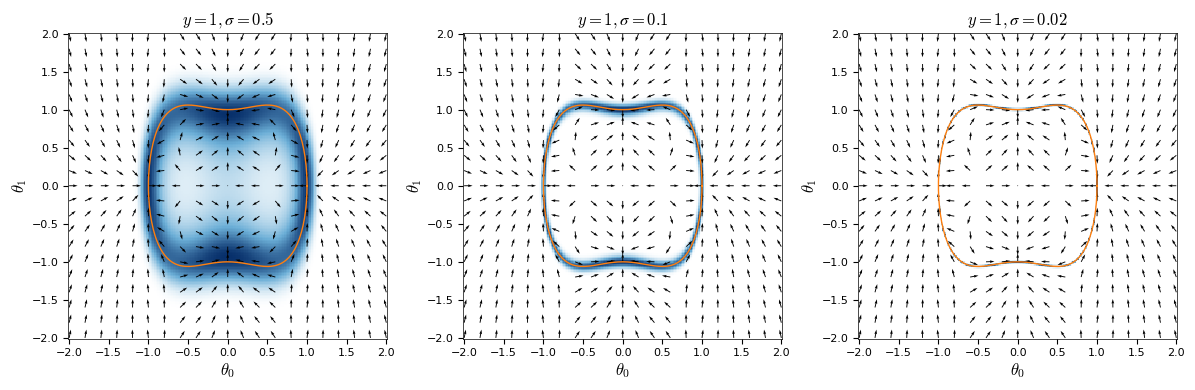

In [30]:
def plot_posterior_density_and_riemannian_grad_field(σ=0.1, y=1.0, ax=None):
    fig, ax = plot_posterior_density_and_limiting_manifold(σ, y, ax)
    θ_grid_grad = θ_grid[:, ::10, ::10]
    metric_field = (
        metric(θ_grid_grad, σ).reshape((dim_θ, dim_θ, -1)).transpose((2, 0, 1))
    )
    grad_field = -grad_neg_log_posterior_dens(θ_grid_grad, σ, y).reshape((dim_θ, -1)).T
    grad_field = np.linalg.solve(metric_field, grad_field).T
    grad_field_norm = np.sum(grad_field**2, 0) ** 0.5
    grad_field[:, grad_field_norm >= 1e-8] /= grad_field_norm[grad_field_norm >= 1e-8]
    ax.quiver(*θ_grid_grad, *(grad_field), angles="xy")
    return fig, ax


interact_or_grid(
    plot_posterior_density_and_riemannian_grad_field,
    figsize=(12, 4),
    σ=((0.02, 1.0, 0.02), (0.5, 0.1, 0.02)),
    y=((-0.1, 2.5), (1,)),
)

We see that in contrast to the Euclidean gradient field, for the Fisher information based metric defined above, the Riemannian gradient field is no longer predominantly normally oriented to the limiting manifold in regions of high posterior density, with instead the Riemannian gradient having a significant tangential component along the limiting manifold in such regions. This suggests the corresponding Hamiltonian dynamics will tend to produce trajectories which preferentially move in directions tangential to the manifold, thus encouraging exploration of the full extent of the region of high posterior density concentrated around the limiting manifold, and avoiding the highly oscillatory dynamics moving back and forth across the limiting manifold which led to the unstable integration of the dynamics previously.

To verify this intuition, we repeat for the Riemannian-manifold HMC algorithm the previous experiment in which visualised the trajectories simulated in HMC proposals for varying noise standard deviations $\sigma$ and integrator step sizes $\epsilon$. Rather than the `EuclideanMetricSystem` we used previously, here we use the `DenseRiemannianMetricSystem` class, which is the appropriate Mici class for Riemannian-manifold Hamiltonian systems where the metric matrix representation is dense. Additional system classes are provided for when the metric matrix representation has a specific structure such as being [diagonal](https://matt-graham.github.io/mici/docs/systems.html#mici.systems.DiagonalRiemannianMetricSystem) or a [product of triangular factors](https://matt-graham.github.io/mici/docs/systems.html#mici.systems.CholeskyFactoredRiemannianMetricSystem) with an explicit functional form. As the Hamiltonian for this system is non-separable (i.e. including at least one additive term which depends on both the position and momentum variables) we can no longer use the standard (explicit) leapfrog integrator, and instead here use a generalised leapfrog integrator which uses [implicit steps](https://en.wikipedia.org/wiki/Explicit_and_implicit_methods). Following Girolami and Calderhead (2011), the non-linear systems of equations defined by these steps are solved by default with a simple direct [fixed-point iteration](https://en.wikipedia.org/wiki/Fixed-point_iteration). This iterative solver may fail to converge and there may be multiple solutions such that a solve in the time-reversed step may converge to a different solution. Therefore in addition to rejecting due to divergence of the Hamiltonian dynamics integration, for this implicit integrator we may also reject early due to a convergence error in the fixed point iteration or non-reversible step.

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

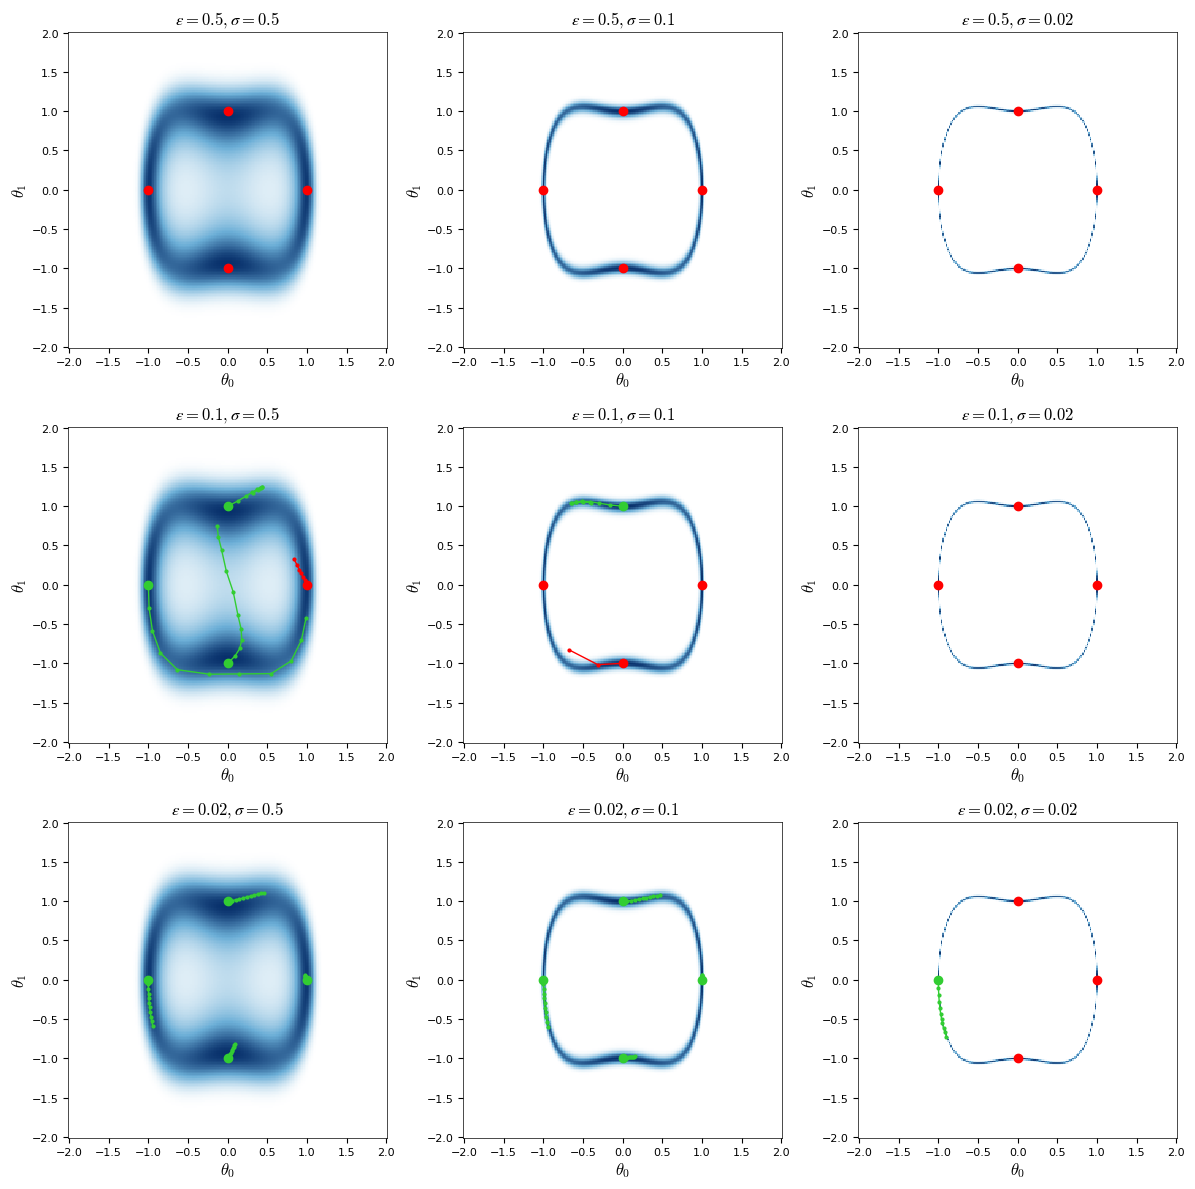

In [31]:
def plot_rmhmc_proposals(σ=0.1, ϵ=0.1, y=1, n_step=20, n_particle=4, ax=None):
    system = mici.systems.DenseRiemannianMetricSystem(
        neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
        grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y),
        metric_func=partial(metric, σ=σ),
        vjp_metric_func=partial(vjp_metric, σ=σ),
    )
    integrator = mici.integrators.ImplicitLeapfrogIntegrator(system, step_size=ϵ)
    states = [
        mici.states.ChainState(pos=θ, mom=None, dir=1)
        for θ in np.concatenate(solve_for_limiting_manifold(y, n_particle))
    ]
    rng = np.random.default_rng(seed)
    fig, ax = plot_posterior_density(σ, y, ax)
    for state in states:
        plot_trajectory(ax, *simulate_proposal(state, system, integrator, rng, n_step))


interact_or_grid(
    plot_rmhmc_proposals,
    σ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    ϵ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    y=[(-0.1, 2.0), y],
    n_step=[(10, 100, 10), 10],
    n_particle=[(4, 10, 2), 4],
    grid_params=("ε", "σ"),
)

In contrast to the Euclidean metric case, we see that the simulated trajectories here, when they successfully terminate, do not exhibit the high frequency oscillation back and forth across the limiting manifold seen previously, instead more closely following the contours of the posterior density. We still see however that large proportion of simulated trajectories do not terminate successfully resulting in a rejection, and that the proportion of such rejections increases as $\sigma$ is made smaller for a fixed integrator step size $\epsilon$. As this does not appear to be due to the instability of the discretisation of the Hamiltonian dynamics, this suggests the rejections are largely the result of the fixed point iterative solves in the implicit steps failing to converge.

To check if this indeed the case and characterise more precisely how the step size $\epsilon$ needs to scale with $\sigma$ to maintain a non-vanishing acceptance rate, as we previously did for the standard Euclidean-metric HMC method, below we perform a grid search over a logarithmically spaced range of $\sigma$ and $\epsilon$ values to compute the average acceptance probability for short Riemannian-manifold HMC chains. Here as well as recording the average acceptance probability for the chains we also record the proportion of proposals rejected due to convergence errors in the fixed point iterative solves. This information is provided as an additional entry `convergence_error` in the chain statistics dictionary returned by the `sample_chains` method. 

Compared to the equivalent experiment for the standard HMC algorithm, the run time here is significantly longer, despite using fewer samples per chain and integrator steps per proposal. This is a result of the much higher cost of each implicit leapfrog step compared to the explicit leapfrog steps, with two fixed point iterative solves required per step, and each iteration  in these solves requiring evaluating either `metric` or `vjp_metric`. To reduce the compute run time we sample the 4 chains per $(\sigma, \epsilon)$ pair in parallel by specifying the number of processes to distribute the chains across in the `sample_chains` call as equal to the number of chains. Note that doing this for the Euclidean-metric HMC experiments above actually increases run time due to the overhead in distributing the chains across multiple processes outweighing the parallelisation speedup.

Completed: 100%|██████████|121/121 [01:39<00:00, 1.22it/s]

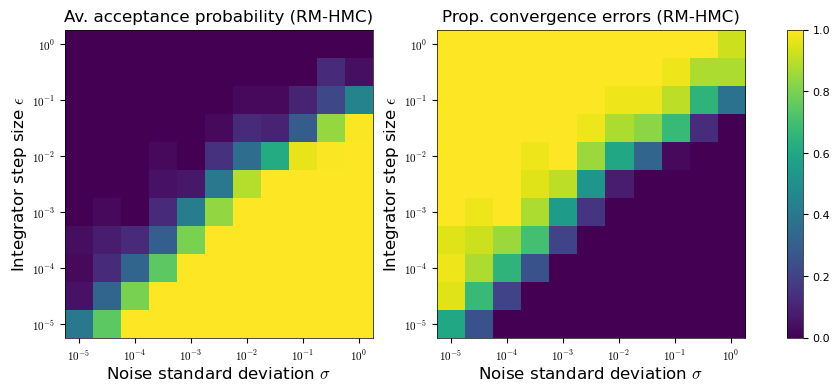

In [32]:
rmhmc_av_accept_probs, rmhmc_prop_conv_error = np.full(
    (2, σ_grid.shape[0], ϵ_grid.shape[0]), np.nan
)

with mici.progressbars.SequenceProgressBar(
    list(enumerate(product(σ_grid, ϵ_grid))), "Completed"
) as pb:
    for (i, (σ, ϵ)), _ in pb:
        system = mici.systems.DenseRiemannianMetricSystem(
            neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
            grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y),
            metric_func=partial(metric, σ=σ),
            vjp_metric_func=partial(vjp_metric, σ=σ),
        )
        integrator = mici.integrators.ImplicitLeapfrogIntegrator(system, step_size=ϵ)
        sampler = mici.samplers.StaticMetropolisHMC(
            system, integrator, rng, n_step=n_step // 2
        )
        _, _, stats = sampler.sample_chains(
            n_warm_up_iter=0,
            n_main_iter=n_sample // 2,
            init_states=θ_inits,
            n_process=n_chain,
            display_progress=False,
        )
        rmhmc_av_accept_probs.flat[i] = np.concatenate(
            [a for a in stats["accept_stat"]]
        ).mean()
        rmhmc_prop_conv_error.flat[i] = np.concatenate(
            [a for a in stats["convergence_error"]]
        ).mean()

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
_ = plot_statistic_heatmap(
    σ_grid,
    ϵ_grid,
    rmhmc_av_accept_probs,
    ax=axes[0],
    title="Av. acceptance probability (RM-HMC)",
    colorbar=False,
)
_ = plot_statistic_heatmap(
    σ_grid,
    ϵ_grid,
    rmhmc_prop_conv_error,
    ax=axes[1],
    title="Prop. convergence errors (RM-HMC)",
)

From the left panel above, we see that though the Riemannian-manifold HMC method seems to allow slightly larger step-sizes $\epsilon$ to be used for a given $\sigma$ with a non-vanishing acceptance probability compared to the standard HMC method, the pattern is still broadly the same with $\epsilon$ needing to be reduced proportionally with $\sigma$ to avoid a zero acceptance rate. Now considering the right panel, showing the proportion of chain iterations ending in a rejection due to a convergence error in one of the fixed point iterations in the implicit integrator steps, we see that most rejections seem to be due to these convergence errors (with the recorded acceptance probability being zero for such iterations). While the Riemannian-manifold HMC proposals therefore seem to overcome the instability in the discretisation of the dynamics encountered previously, the poor convergence properties of the fixed point iterative solver means that sampling efficiency still degrades in the vanishing noise $\sigma \to 0$ limit.

## Lifting the posterior on to a manifold

In the previous section we considered treating the latent space as a manifold with geometry defined [intrinsically](https://en.wikipedia.org/wiki/Manifold#Intrinsic_and_extrinsic_view) via a metric, and adjusting the Hamiltonian dynamics used to generate MCMC proposals to account for the manifold geometry. While the resulting Hamiltonian dynamics using a Fisher information based metric did appear to overcome some of the issues encountered when simulating Hamiltonian dynamics on a Euclidean space, due to the tendency for the iterative solver in the implicit integrator used to simulate dynamics to diverge, we still required to use an integrator step size $\epsilon$ which scaled with the observation noise standard deviation $\sigma$ to maintain a non-vanishing acceptance rate.

An alternative to altering the geometry of the posterior distribution intrinsically via a metric, is to instead *lift* the posterior distribution from the original latent space $\Theta \subseteq \mathbb{R}^{d_\Theta}$ on to a manifold of dimension $d_\Theta$ embedded in a higher-dimensional ambient space $\Theta \times \dots$, such that the distribution of the projection back onto $\Theta$ corresponds to the posterior distribution $\pi^\sigma$. A particularly natural lifting is provided by the generative structure of the model: if rather than considering the unknowns to be inferred as just the latent quantity of interest $\boldsymbol{\theta}$ we also include the Gaussian observation noise vector $\boldsymbol{\eta}$ then the set of $(\boldsymbol{\theta}, \boldsymbol{\eta}) \in  \Theta \times \mathcal{Y} = \mathbb{R}^{d_\Theta + d_{\mathcal{Y}}}$ pairs consistent with the observations, i.e. $\mathcal{M}^\sigma = \lbrace (\boldsymbol{\theta}, \boldsymbol{\eta}) \in  \Theta \times \mathcal{Y} :  \boldsymbol{y} = F(\boldsymbol{\theta}) + \sigma \boldsymbol{\eta} \rbrace$, defines a manifold of dimension $d_\Theta$ embedded in $\mathbb{R}^{d_\Theta + d_{\mathcal{Y}}}$. If we lift the posterior distribution on to the manifold $\mathcal{M}^\sigma$ we get a distribution with density

$$
  \bar{\pi}^\sigma(\boldsymbol{\theta},\boldsymbol{\eta}) \propto 
  \frac{\exp\big( -\Phi_0(\boldsymbol{\theta}) - \frac{1}{2}\boldsymbol{\eta}^\mathsf{T}\boldsymbol{\eta} \big) \mathbb{1}_{\mathcal{M}^\sigma}(\boldsymbol{\theta},\boldsymbol{\eta})}
       {\big| \mathbf{D}F(\boldsymbol{\theta})\mathbf{D}F(\boldsymbol{\theta})^\mathsf{T} + \sigma^2 \mathbf{I}_{d_\mathcal{Y}} \big|^\frac{1}{2}}
$$

with respect to the [*Hausdorff measure*](https://en.wikipedia.org/wiki/Hausdorff_measure) of dimension $d_\Theta$ on the ambient space $\mathbb{R}^{d_\Theta + d_{\mathcal{Y}}}$. This density can be interpreted as the joint prior density on $\boldsymbol{\theta}$ and $\boldsymbol{\eta}$, restricted to the manifold $\mathcal{M}^\sigma$ and adjusted by a Jacobian determinant term that accounts for the difference in the Hausdorff measure (area) of local patches of the lifted manifold versus the Lebesgue measure of their projection on to the original $\Theta$ space. We can construct a function to evaluate the (negative logarithm) of this density for our toy model in SymNum as follows.

In [33]:
@numpify(dim_θ, None, None, None)
def neg_log_lifted_posterior_dens(θ, η, σ, y):
    jac = jacobian(forward_func)(θ)
    return snp.sum(θ**2, 0) / 2 + η**2 / 2 + snp.log(jac @ jac.T + σ**2)[0, 0] / 2

If we fix the value of $\boldsymbol{\eta}$ the corresponding values of $\boldsymbol{\theta}$ on the manifold, i.e. such that $(\boldsymbol{\theta},\boldsymbol{\eta}) \in \mathcal{M}^\sigma$, correspond to the preimage of the 'denoised' observation $\boldsymbol{y} - \sigma \boldsymbol{\eta}$ under the forward function $F$ i.e. $\boldsymbol{\theta} \in F^{-1}(\boldsymbol{y} - \sigma \boldsymbol{\eta})$. For our simple running example $\boldsymbol{\eta}$ is one-dimensional and the preimage under $F$ of a point is a closed one-dimensional manifold (corresponding to the levels sets of $F$ visualised previously), and so we can visualise the two-dimensional manifold $\mathcal{M}^\sigma$ as a 'stack' of 1D slices in the $\Theta$ plane, each corresponding to the preimage $F^{-1}(y - \sigma \eta)$ for a particular $\eta$ value. Previously we encountered the preimage of $F$ in the context of the limiting manifold $\mathcal{S}$ as $\sigma \to 0$ for a fixed set of observations $\boldsymbol{y}$ and used SymPy to symbolically solve for the preimage. Although this approach is general and can be straightforwardly applied to a new forward function, symbolically solving for the preimage for a fine grid of $\eta$ values is relatively time-consuming to run. Therefore below we define a 'hard-coded' NumPy function to output a set of points spanning the preimage $F^{-1}(y)$ for a point $y$ under the specific forward function defined previously, and an additional function which builds up a stack of these 'slices' for a range of $\eta$ values.

In [34]:
def forward_func_preimage_points(y, n_point):
    t = np.linspace(-1, 1, n_point)
    r, s = -np.cos(np.pi * t), np.sign(t)
    θ_0 = ((1 + (1 + 4 * y / 3) ** 0.5 - 1e-10) / 2) ** 0.5 * r
    θ_1 = s * np.sqrt(y - 3 * θ_0**2 * (θ_0**2 - 1))
    return np.stack((θ_0, θ_1), -1)


def manifold_points(σ, y, n_η_vals=50, n_θ_vals=200, η_min_plot=-2.0, η_max_plot=2.0):
    eps = np.finfo(np.float64).eps
    η_grid = np.linspace(η_min_plot + eps, η_max_plot - eps, n_η_vals)
    θ_points = np.empty((dim_θ,) + (n_η_vals, n_θ_vals))
    η_points = np.tile(η_grid, (n_θ_vals, 1)).T
    for i, η in enumerate(η_grid):
        θ_points[:, i] = forward_func_preimage_points(y - σ * η, n_θ_vals).T
    return θ_points, η_points

Using the above two functions we now visualise the manifold $\mathcal{M}^\sigma$ and density of the lifted posterior distribution $\bar{\pi}^\sigma$ on the manifold for different $\sigma$ values (and a fixed observation $y=1$). We plot the lifted density as in green (with higher intensity indicating higher density) on a surface plot of the manifold and overlay with a grid to help make the three-dimensional shape of the manifold clearer (in the interactive version of the plot the view can also be rotated by specifying the azimuth and elevation angles of the camera). The corresponding posterior density on the original $\Theta$ space is shown below in the manifold in blue.

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

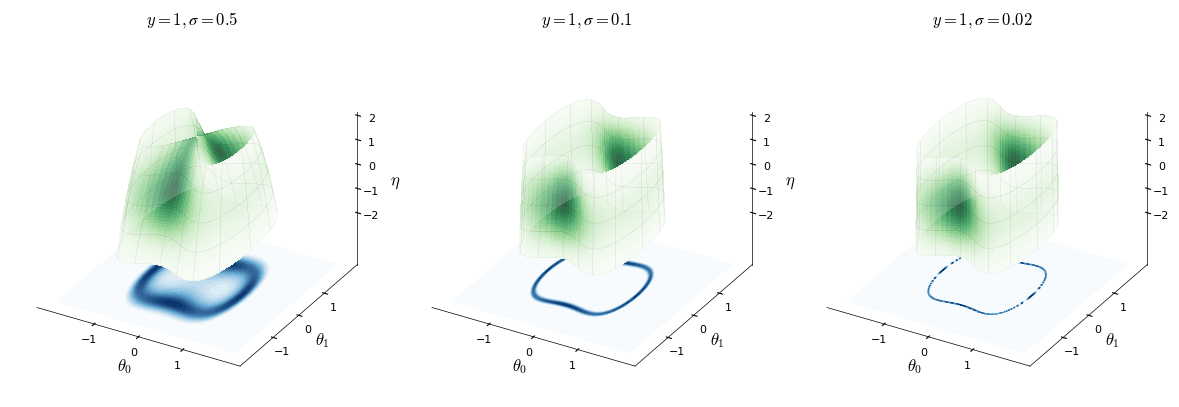

In [35]:
def plot_manifold_and_density(
    σ=0.1, y=1.0, azim=-60, elev=30, projection="persp", ax=None
):
    fig, ax = create_fig_if_none(ax, subplot_kw={"projection": "3d"})
    θ_points, η_points = manifold_points(σ, y, 40, 80, -2, 2)
    lifted_density_grid = np.exp(
        -neg_log_lifted_posterior_dens(θ_points, η_points, σ, y)
    )
    density_grid = np.exp(-neg_log_posterior_dens(θ_grid, σ, y))
    # plot lifted density on manifold
    ax.plot_surface(
        θ_points[0],
        θ_points[1],
        η_points,
        facecolors=plt.cm.Greens(mcolors.Normalize()(lifted_density_grid)),
        edgecolor="none",
        shade=False,
        cstride=1,
        rstride=1,
        antialiased=False,
        linewidth=0.0,
    )
    # plot grid 'overlay' over manifold to make shape clearer
    ax.plot_surface(
        θ_points[0],
        θ_points[1],
        η_points,
        alpha=0.2,
        color="w",
        edgecolor=(0, 0, 0, 1),
        shade=False,
        cstride=5,
        rstride=10,
        antialiased=True,
        linewidth=0.1,
    )
    # plot density on original space as filled contour plot below manifold
    ax.contourf(θ_grid[0], θ_grid[1], density_grid, 20, offset=-4, cmap=dens_cmap)
    ax.set(
        xlabel=r"$\theta_0$",
        ylabel=r"$\theta_1$",
        zlabel=r"$\eta$",
        xticks=[-1, 0, 1],
        yticks=[-1, 0, 1],
        zticks=[-2, -1, 0, 1, 2],
        zlim=(-4, 2),
        proj_type=projection,
    )
    ax.tick_params(axis="both", which="major", pad=-2)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.labelpad = -5
        axis.pane.fill = False
        axis.set_rotate_label(False)
        axis.pane.set_edgecolor("w")
    ax.grid(False)
    ax.view_init(elev, azim)


interact_or_grid(
    plot_manifold_and_density,
    figsize=(12, 4),
    subplot_kw={"projection": "3d"},
    σ=[(0.02, 0.5, 0.08), (0.5, 0.1, 0.02)],
    y=[fixed(1), (1,)],
    azim=[(-180, 180, 30), -60],
    elev=[(0, 90, 15), 30],
    projection=([("Perspective", "persp"), ("Orthogonal", "ortho")], "ortho"),
)

We see that the lifted distribution $\bar{\pi}^\sigma$ remains diffuse as the observation noise vanishes $\sigma \to 0$ even as the original posterior density $\pi^\sigma$ concentrates on the limiting manifold. This suggests that if we can construct a Markov chain targeting the lifted posterior distribution we may be able to avoid the requirement to scale the step size $\epsilon$ with $\sigma$ to maintain a reasonable acceptance rate. Further we see that as $\sigma$ becomes smaller the subset of the manifold $\mathcal{M}^\sigma$ in the high-probability $\eta$ range becomes increasingly close to the 'cylinder-like' product manifold $\mathcal{S} \times \mathcal{Y}$ (where $\mathcal{S} = F^{-1}(y)$ as previously). This suggests that as $\sigma$ becomes smaller the geometry of the manifold $\mathcal{M}^\sigma$ becomes in some sense simpler with vanishing curvature in the $\eta$ direction, and so we might not expect simulating a Markov chain on $\mathcal{M}^\sigma$ to become more challenging as $\sigma \to 0$.

## Constrained Hamiltonian Monte Carlo on lifted distribution

To construct a Markov chain targeting the lifted distribution we use a [*constrained Hamiltonian Monte Carlo*](https://arxiv.org/abs/1807.02356) method, based on simulating the Hamiltonian dynamics of a constrained mechanical system. We denote the concatenated latent state as $\boldsymbol{q} = (\boldsymbol{\theta},\boldsymbol{\eta})$ and an associated auxiliary momentum variable as $\boldsymbol{p}$. We then define a *constraint function* $C : \mathbb{R}^{d_\Theta + d_{\mathcal{Y}}} \to \mathbb{R}^{d_{\mathcal{Y}}}$ the zero level-set of which corresponds to the set of constraint-satisfying configurations $\boldsymbol{q}$. Here we specify the constraint function as $C((\boldsymbol{\theta},\boldsymbol{\eta})) = F(\boldsymbol{\theta}) + \sigma \boldsymbol{\eta} - \boldsymbol{y}$ such that its zero level-set corresponds to the manifold $\mathcal{M}^\sigma$. The dynamics of a constrained Hamiltonian system with potential energy function $\bar{U}$ and identity metric matrix representation (mass matrix) are then described by the following system of differential algebraic equations (DAEs)
$$
  \dot{\boldsymbol{q}} = \boldsymbol{p},
  \quad
  \dot{\boldsymbol{p}} = -\nabla\bar{U}(\boldsymbol{q}) -
  \mathbf{D}C(\boldsymbol{q})^\mathsf{T} \boldsymbol{\lambda},
  \quad
  C(\boldsymbol{q}) = \boldsymbol{0}.
$$

The Lagrange multipliers $\boldsymbol{\lambda}$ are implicitly defined functions of $\boldsymbol{p}$ and $\boldsymbol{q}$ such that the constraint equation $C(\boldsymbol{q}) = \boldsymbol{0}$ is satisfied at all times. By differentiating the constraint equation with respect to time and using that $\dot{\boldsymbol{q}} = \boldsymbol{p}$ we derive a set of constraints on the momenta: $\mathbf{D}C(\boldsymbol{q}) \boldsymbol{p} = \boldsymbol{0}$, corresponding to a requirement that the momentum is tangential to constraint manifold at all time points.

The constrained Hamiltonian dynamics can be simulated using a 'constrained leapfrog' integrator which interleaves steps simulating one of a splitting of the unconstrained dynamics $\dot{\boldsymbol{q}} = \boldsymbol{0}, \dot{\boldsymbol{p}} = -\nabla\bar{U}(\boldsymbol{q})$ and $\dot{\boldsymbol{q}} = \boldsymbol{p}, \dot{\boldsymbol{p}} = \boldsymbol{0}$ with steps simulating $\dot{\boldsymbol{q}} = \boldsymbol{0}, \dot{\boldsymbol{p}} = -\mathbf{D}C(\boldsymbol{q})^\mathsf{T} \boldsymbol{\lambda}$ and solving for the Lagrange multipliers $\boldsymbol{\lambda}$ such that position constraint equation $C(\boldsymbol{q}) = \boldsymbol{0}$ and momentum constraint equations $\mathbf{D}C(\boldsymbol{q}) \boldsymbol{p} = \boldsymbol{0}$ are satisfied. Finding $\boldsymbol{\lambda}$ such that the momentum constraints are satisfied can be done explicitly by solving a linear system in $\mathbf{D}C(\boldsymbol{q})\mathbf{D}C(\boldsymbol{q})^\mathsf{T}$, however solving for the position constraints requires solving a non-linear system of the form $C(\tilde{\boldsymbol{q}} - \mathbf{D}C(\boldsymbol{q})^\mathsf{T}\boldsymbol{\lambda}) = \boldsymbol{0}$ in $\boldsymbol{\lambda}$ for which an iterative solver such as a ([quasi-](https://en.wikipedia.org/wiki/Quasi-Newton_method))[Newton method](https://en.wikipedia.org/wiki/Newton%27s_method) must be used. As for the implicit leapfrog integrator used to simulate the Riemannian-manifold Hamiltonian dynamics, the use of an iterative solver in the constrained leapfrog integrator means that we must explicitly check that both forward and time-reversed steps converge and to corresponding solutions such that the step is time-reversible, with an error being raised (and the trajectory terminated) if the the iterative solves in either forward or reversed steps fail to converge, or converge to solutions that make the step non-reversible.

The resulting constrained leapfrog integrator is (subject to the additional checks) time-reversible and preserves a volume element corresponding to the reference Hausdorff measure for the lifted posterior density $\bar{\pi}^\sigma$. A constrained HMC method targeting $\bar{\pi}^\sigma$ can therefore be constructed by simulating the constrained Hamiltonian dynamics with potential energy function $\bar{U}((\boldsymbol{\theta},\boldsymbol{\eta})) = -\log\bar{\pi}^\sigma(\boldsymbol{\theta},\boldsymbol{\eta})$ and accepting or rejecting the proposed move in a Metropolis correction based on the change in the Hamiltonian $\bar{H}(\boldsymbol{q},\boldsymbol{p}) = \bar{U}(\boldsymbol{q}) + \frac{1}{2}\boldsymbol{p}^\mathbf{T}\boldsymbol{p}$. For a standard normal prior on $\boldsymbol{\theta}$ and using that $\mathbf{D}C((\boldsymbol{\theta},\boldsymbol{\eta}))\boldsymbol{D}C((\boldsymbol{\theta},\boldsymbol{\eta}))^\mathsf{T} = \mathbf{D}F(\boldsymbol{\theta})\mathbf{D}F(\boldsymbol{\theta})^\mathsf{T} + \sigma^2 \mathbf{I}_{d_\mathcal{Y}}$ we have that the potential energy function is

$$\bar{U}(\boldsymbol{q}) = \frac{1}{2}\boldsymbol{q}^\mathsf{T}\boldsymbol{q} + \frac{1}{2} \log\left| \mathbf{D}C(\boldsymbol{q})\boldsymbol{D}C(\boldsymbol{q})^\mathsf{T} \right|$$

with corresponding gradient

$$
  \nabla \bar{U}(\boldsymbol{q}) = \boldsymbol{q} + \mathsf{MHP}(C)(\boldsymbol{q})
  \big((\mathbf{D}C(\boldsymbol{q})\boldsymbol{D}C(\boldsymbol{q})^\mathsf{T})^{-1}\mathbf{D}C(\boldsymbol{q})\big).
$$

In the gradient expression the 'matrix-Hessian-product' operator $\mathsf{MHP}$ can be defined in terms of the 'vector-Jacobian-product' $\mathsf{VJP}$ and Jacobian $\mathbf{D}$ operators introduced previously as $\mathsf{MHP}(C) = \mathsf{VJP}(\mathbf{D}C)$.

The constraint Jacobian $\mathbf{D}C(\boldsymbol{q})$ is required for evaluating both the potential energy (and its gradient) and in solving for the Lagrange multipliers in the constrained integrator step. The relevant Mici class in `mici.systems` for a constrained Hamiltonian system is `DenseConstrainedEuclideanMetricSystem` corresponding to a constrained Euclidean metric system with dense constraint Jacobian. To avoid redundantly recalculating the constraint Jacobian, this class accepts a keyword argument `dens_wrt_hausdorff` which when set to `False` allows the `neg_log_dens` argument (and corresponding gradient `grad_neg_log_dens`) to be set to the negative logarithm of the prior density term on $\boldsymbol{q}$, with the additional log-determinant term in the potential energy $\bar{U}$ to correct for the change of reference measure from the Lebesgue measure to the Hausdorff measure being automatically added using a Jacobian calculated using the separately specified constraint Jacobian function `jacob_constr`. As well an argument `constr` specifying the constraint function itself, the system class additionally takes a `mhp_constr` argument corresponding to the 'matrix-Hessian-product' operator described above applied to the constraint function, to allow calculation of the gradient of the log-determinant term. Functions to compute all these quantities are constructed below using SymNum.


In [36]:
@numpify(dim_θ + dim_y)
def neg_log_prior_dens(q):
    return snp.sum(q**2) / 2


grad_neg_log_prior_dens = grad(neg_log_prior_dens)


@numpify(dim_θ + dim_y, None, None)
def constr(q, σ, y):
    θ, η = q[:dim_θ], q[dim_θ:]
    return forward_func(θ) + σ * η - y


jacob_constr = jacobian(constr, return_aux=True)
mhp_constr = matrix_hessian_product(constr, return_aux=True)

We are now in a position to repeat the visualisation of simulated proposals for different noise standard deviations $\sigma$ and integrator step sizes $\epsilon$ created earlier for the standard HMC and Riemannian-manifold HMC methods, for the constrained HMC method on the lifted distribution. The function below constructs an instance of the `DenseConstrainedEuclideanMetricSystem` class using the functions just constructed (with the values of $\sigma$ and $y$ fixed using the `partial` operator) and also constructs a `ConstrainedLeapfrogIntegrator` instance from the `mici.integrators` module, corresponding to the Mici implementation of the constrained leapfrog integrator described above. Here we use a full Newton method (rather than the symmetric quasi-Newton method described in the paper) to solve for the Lagrange multipliers to satisfy the position constraints. This requires reevaluating the constraint Jacobian inside the solver iteration and so can be inefficient for models in which the constraint Jacobian costs significantly more to evaluate than the constraint function. However, for our toy model, both constraint function and Jacobian have a similar evaluation cost, so the improved convergence rate of the Newton method wins out. To initialise the chains we need to find an initial set of points $\boldsymbol{q} \in \mathcal{M}^\sigma$. Here we use the that $(\boldsymbol{\theta}, (\boldsymbol{y}-F(\boldsymbol{\theta}))/ \sigma)$ is a point in $\mathcal{M}^\sigma$ for any choice of $\boldsymbol{\theta}$, choosing the $\boldsymbol{\theta}$ values on the limiting manifold $\mathcal{S}$ as previously.

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

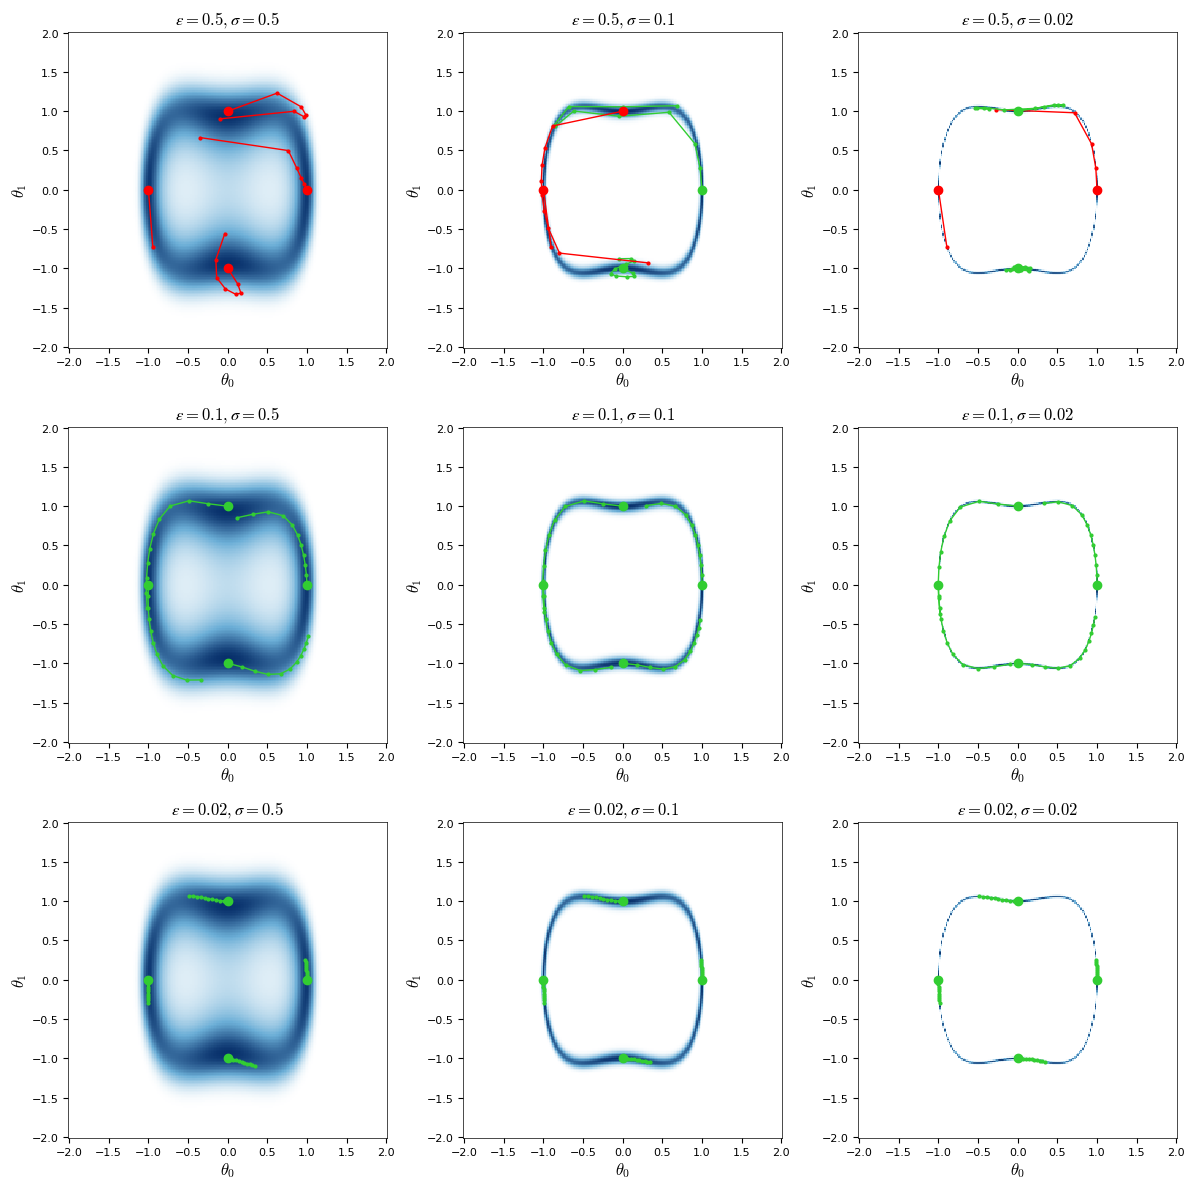

In [37]:
def plot_chmc_proposals(σ=0.1, ϵ=0.1, y=1, n_step=20, n_particle=4, ax=None):
    system = mici.systems.DenseConstrainedEuclideanMetricSystem(
        neg_log_dens=neg_log_prior_dens,
        grad_neg_log_dens=grad_neg_log_prior_dens,
        dens_wrt_hausdorff=False,
        constr=partial(constr, σ=σ, y=y),
        jacob_constr=partial(jacob_constr, σ=σ, y=y),
        mhp_constr=partial(mhp_constr, σ=σ, y=y),
    )
    integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
        system,
        step_size=ϵ,
        projection_solver=mici.solvers.solve_projection_onto_manifold_newton,
    )
    states = [
        mici.states.ChainState(
            pos=np.concatenate([θ, (y - forward_func(θ)) / σ]), mom=None, dir=1
        )
        for θ in np.concatenate(solve_for_limiting_manifold(y, n_particle))
    ]
    rng = np.random.default_rng(seed)
    fig, ax = plot_posterior_density(σ, y, ax)
    for state in states:
        plot_trajectory(ax, *simulate_proposal(state, system, integrator, rng, n_step))


interact_or_grid(
    plot_chmc_proposals,
    σ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    ϵ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)],
    y=[(-0.1, 2.0), y],
    n_step=[(10, 100, 10), 10],
    n_particle=[(4, 10, 2), 4],
    grid_params=("ε", "σ"),
)

As with the Riemannian-manifold HMC trajectory proposals, the trajectories here show the desirable behaviour of mainly moving tangentially around the limiting manifold without the high frequency oscillation in directions normal to the limiting manifold seen for the (Euclidean) HMC proposals. In fact as explained in Appendix A in the paper, the projection on the $\Theta$ space of the continuous time dynamic being simulated in the constrained HMC method is exactly equivalent to the Riemannian-manifold dynamic with Fisher information based metric discussed above. However unlike the Riemannian-manifold HMC case, here we do not see an increased number of rejected proposals as $\sigma$ is made smaller for a fixed integrator step size $\epsilon$, with most proposals being accepted irrespective of the value of $\sigma$ providing $\epsilon$ is below some upper bound. This suggests we do not need to take smaller steps and so expend a greater computational effort to move a certain distance in the latent space as $\sigma$ becomes smaller for this approach of applying constrained HMC to the lifted distribution.

We can see this pattern even more clearly by performing a grid search over a logarithmically spaced range of $\sigma$ and $\epsilon$ values and computing the average acceptance probability for short constrained HMC chains running on the lifted distribution. As for the equivalent Riemannian-manifold HMC experiment, as well as recording the average acceptance probability for the chains we also record the proportion of proposals rejected due to convergence errors in the iterative solves of the projection steps. We use the same settings of running 4 chains of 20 samples with 20 integrator steps per proposal for each $\sigma$ and $\epsilon$ pair as for the Euclidean HMC experiments (compared to the 10 samples per chain and 10 integrator steps per proposal for Riemannian-manifold HMC), and run the 4 chains in parallel. Although the run-time for the experiments is longer than for the Euclidean HMC chains, it remains similar to the run-time of the Riemannian-manifold chains despite the use of twice as many chain samples and steps per proposal, with both methods using integrators in which iterative methods are used to solve non-linear equations. This can be explained by the improved convergence rate of the Newton method solver used in the constrained leapfrog integrator compared to the simple fixed point iteration in the implicit leapfrog integrator, and the requirement to perform just one iterative solve per step for the constrained leapfrog integrator compared to two for the implicit leapfrog integrator.

Completed: 100%|██████████|121/121 [01:37<00:00, 1.25it/s]

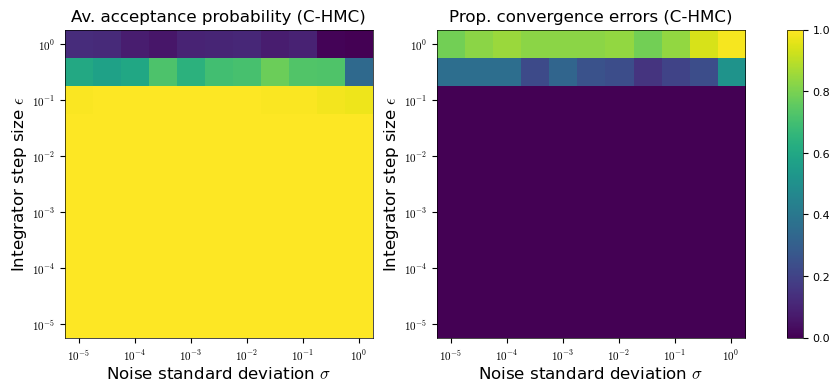

In [38]:
chmc_av_accept_probs, chmc_prop_conv_error = np.full(
    (2, σ_grid.shape[0], ϵ_grid.shape[0]), np.nan
)

with mici.progressbars.SequenceProgressBar(
    list(enumerate(product(σ_grid, ϵ_grid))), "Completed"
) as pb:
    for (i, (σ, ϵ)), _ in pb:
        q_inits = [np.concatenate([θ, (y - forward_func(θ)) / σ]) for θ in θ_inits]
        system = mici.systems.DenseConstrainedEuclideanMetricSystem(
            neg_log_dens=neg_log_prior_dens,
            grad_neg_log_dens=grad_neg_log_prior_dens,
            dens_wrt_hausdorff=False,
            constr=partial(constr, σ=σ, y=y),
            jacob_constr=partial(jacob_constr, σ=σ, y=y),
            mhp_constr=partial(mhp_constr, σ=σ, y=y),
        )
        integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
            system,
            step_size=ϵ,
            projection_solver=mici.solvers.solve_projection_onto_manifold_newton,
        )
        sampler = mici.samplers.StaticMetropolisHMC(
            system, integrator, rng, n_step=n_step
        )
        _, _, stats = sampler.sample_chains(
            n_warm_up_iter=0,
            n_main_iter=n_sample,
            init_states=q_inits,
            n_process=n_chain,
            display_progress=False,
        )
        chmc_av_accept_probs.flat[i] = np.concatenate(
            [a for a in stats["accept_stat"]]
        ).mean()
        chmc_prop_conv_error.flat[i] = np.concatenate(
            [a for a in stats["convergence_error"]]
        ).mean()

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
_ = plot_statistic_heatmap(
    σ_grid,
    ϵ_grid,
    chmc_av_accept_probs,
    ax=axes[0],
    title="Av. acceptance probability (C-HMC)",
    colorbar=False,
)
_ = plot_statistic_heatmap(
    σ_grid,
    ϵ_grid,
    chmc_prop_conv_error,
    ax=axes[1],
    title="Prop. convergence errors (C-HMC)",
)

We see that as suggested by the trajectory visualisations above, the constrained HMC method maintains a high acceptance rate providing the step size $\epsilon$ is below some upper bound **which is independent of the value of the noise standard deviation $\sigma$**. Above an integrator step size $\epsilon$ of around 0.1 we start to see an increasing number of rejections due to convergence errors in the Newton method used to solve the non-linear system of equations to project points back on to the manifold in the constrained integrator. This suggests the integrator step size is limited here by the curvature of the manifold $\mathcal{M}^\sigma$. The local linear approximation made for the unconstrained step before projecting back on to the manifold becomes poorer as the step size is increased for curved manifolds, with the Newton solver becoming increasingly unlikely to be able to successfully project back on the manifold beyond a certain step size. We saw previously in our toy running example the variation in curvature across the high probability regions on the manifold $\mathcal{M}^\sigma$ decreases as $\sigma \to 0$ and it tends to a product manifold $\mathcal{S} \times \mathcal{Y}$, thus $\sigma$ becoming smaller does not adversely effect this limit on the step size.

Importantly these results suggest that for sufficiently small $\sigma$ the sampling performance of our proposed constrained HMC approach will dominate over that of standard (Euclidean) or Riemannian-manifold HMC, as the constrained HMC method will be able to take fewer larger steps to move a given distance in the latent space and so less computational effort will be needed to produce a certain effective sample size. In the final section below we verify this claim.

## Sampling efficiency comparison

Up to till now we have only considered the average acceptance probability as a proxy metric of sampling performance, however in reality we are more interested in the accuracy of the Monte Carlo estimates of posterior expectations we can compute for a given computational expenditure. Below we run longer chains for each of Euclidean HMC, Riemannian-manifold HMC and constrained HMC on the lifted target distribution, for a fixed values $\sigma = 0.02$ and $y = 1$, and for each use [ArviZ](https://arviz-devs.github.io/arviz/) to compute [an estimate of the $\hat{R}$ convergence diagnostic and the estimated effective sample size](https://avehtari.github.io/rhat_ess/rhat_ess.html) normalised by the chain run time. We also plot traces of the chains to visualise more directly how well they explore the region of high posterior density. 

Rather than use a predetermined fixed number of integrator steps in each proposal, we use a dynamic integration time HMC implementation which iteratively expands the simulated trajectory (both forwards and backwards in time) until a heuristic criterion indicates the trajectory has 'U-turned' and further expansion will not increase the distance move in the latent space. The `DynamicSliceHMC` and `DynamicMultinomialHMC` sampler classes in the `mici.samplers` module implement such dynamic integration time HMC algorithms, with the former corresponding to the original 'no U-turn sampler' (NUTS) method [(Hoffman and Gelman, 2014)](http://jmlr.org//papers/v15/hoffman14a.html) and the latter a more efficient variant [(Betancourt, 2017)](https://arxiv.org/abs/1701.02434) currently used as the default sampler in the probabilistic programming framework [Stan](https://mc-stan.org/).

In [39]:
σ = 0.02
y = 1.0


def plot_traces(traces, σ, y):
    n_chain = len(traces["pos"])
    fig, axes = plt.subplots(2, n_chain // 2, figsize=(12, 6 * n_chain // 2))
    for i, (pos_trace, ax) in enumerate(zip(traces["pos"], axes.flat)):
        _ = plot_posterior_density(σ=σ, y=y, ax=ax)
        ax.set_title(f"Chain {i + 1}")
        ax.plot(*pos_trace.T[:dim_θ], ".", ms=1, color=f"C1")
    return fig, axes


def print_rhat_and_time_normalised_ess(traces, run_time):
    r_hat = arviz.rhat(traces).pos
    n_effective_samples = arviz.ess(traces).pos
    for i in range(dim_θ):
        ess_per_run_time = float(n_effective_samples[i]) / run_time
        print(
            f"θ[{i}]: estimated R̂ = {float(r_hat[i]):#.3g} and "
            f"effective samples per run time = {ess_per_run_time:#.3g} s⁻¹"
        )

### Euclidean Hamiltonian Monte Carlo

For the standard Euclidean HMC algorithm we run four chains of 1000 iterations and use a step size of $\epsilon = 0.1 \sigma$. Though step sizes larger than this still give reasonable acceptance probabilities we find that at larger step sizes the chains will typically remained confined to one portion of the loop of high posterior density, with the leapfrog integrator unable to successfully traverse through the narrow 'vertical' sections of the loop, with the integrator typically becoming unstable and diverging in these regions. 

Sampling stage: Main non-adaptive [01:29]

Chain 1/4: 100%|██████████|1000/1000 [01:27<00:00, 11.48it/s, accept_stat=0.993, diverging=0.00]

Chain 2/4: 100%|██████████|1000/1000 [01:28<00:00, 11.33it/s, accept_stat=0.993, diverging=0.00]

Chain 3/4: 100%|██████████|1000/1000 [01:25<00:00, 11.72it/s, accept_stat=0.992, diverging=0.00]

Chain 4/4: 100%|██████████|1000/1000 [01:28<00:00, 11.26it/s, accept_stat=0.993, diverging=0.00]

θ[0]: estimated R̂ = 1.00 and effective samples per run time = 6.36 s⁻¹
θ[1]: estimated R̂ = 1.02 and effective samples per run time = 2.63 s⁻¹


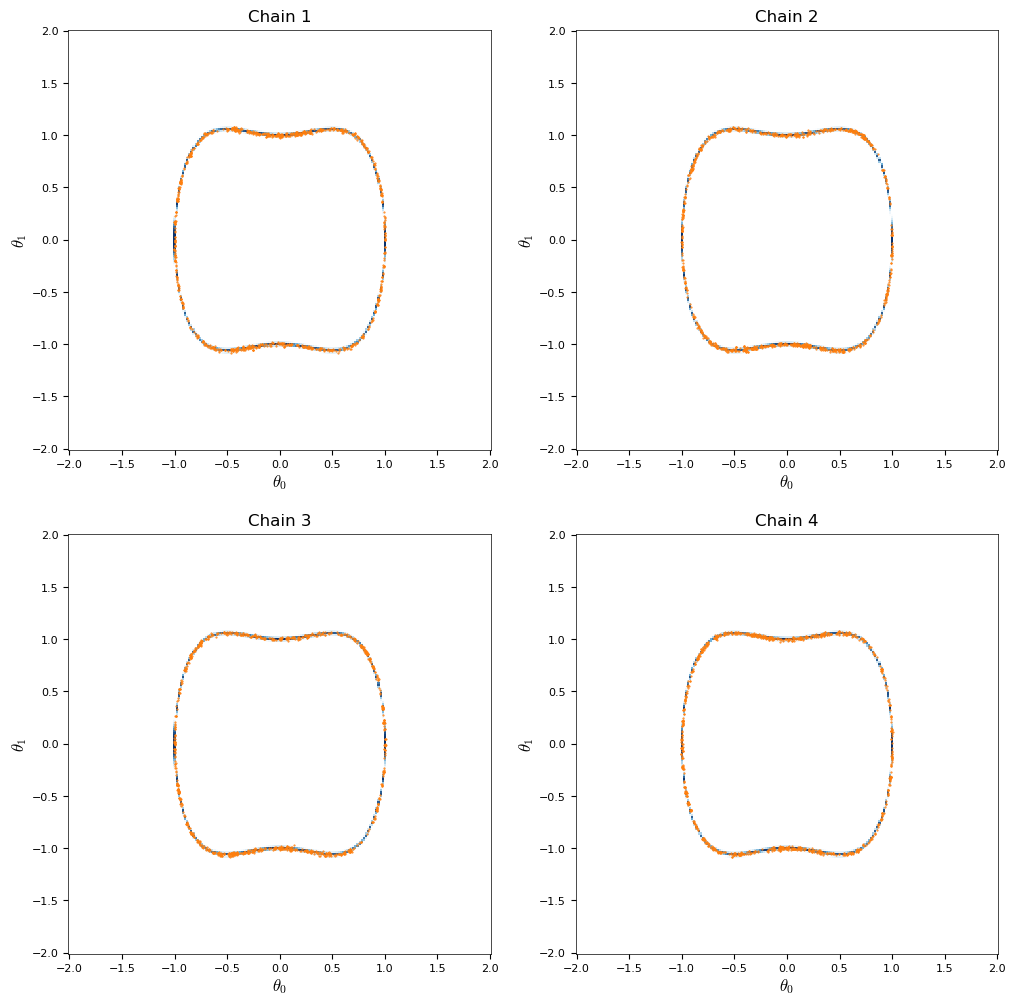

In [40]:
def sample_hmc_chains(σ, y, ϵ, n_chain, n_iter):
    system = mici.systems.EuclideanMetricSystem(
        neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
        grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y),
    )
    integrator = mici.integrators.LeapfrogIntegrator(system, step_size=ϵ)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    θ_inits = np.concatenate(solve_for_limiting_manifold(y, n_chain))
    start_time = time.time()
    final_states, traces, stats = sampler.sample_chains(
        n_warm_up_iter=0,
        n_main_iter=n_iter,
        init_states=θ_inits,
        n_process=n_chain,
        monitor_stats=["accept_stat", "diverging"],
    )
    run_time = time.time() - start_time
    return traces, run_time


hmc_traces, hmc_run_time = sample_hmc_chains(σ, y, 0.1 * σ, n_chain, 1000)
print_rhat_and_time_normalised_ess(hmc_traces, hmc_run_time)
fig, axes = plot_traces(hmc_traces, σ, y)

### Riemannian-manifold Hamiltonian Monte Carlo

Due to the high computational cost of running the Riemannian-manifold HMC method we only run short chains of 500 iterations here. We use an integrator step size $\epsilon = 0.3 \sigma$ with larger values typically leading to a large proportion of proposals being rejected due to a convergence error in the fixed point iterations. 

Sampling stage: Main non-adaptive [02:30]

Chain 1/4: 100%|██████████|500/500 [01:44<00:00, 4.77it/s, accept_stat=0.596, convergence_error=0.368]

Chain 2/4: 100%|██████████|500/500 [02:11<00:00, 3.81it/s, accept_stat=0.501, convergence_error=0.446]

Chain 3/4: 100%|██████████|500/500 [01:59<00:00, 4.20it/s, accept_stat=0.519, convergence_error=0.438]

Chain 4/4: 100%|██████████|500/500 [02:30<00:00, 3.33it/s, accept_stat=0.725, convergence_error=0.264]

θ[0]: estimated R̂ = 2.31 and effective samples per run time = 0.0335 s⁻¹
θ[1]: estimated R̂ = 2.41 and effective samples per run time = 0.0330 s⁻¹


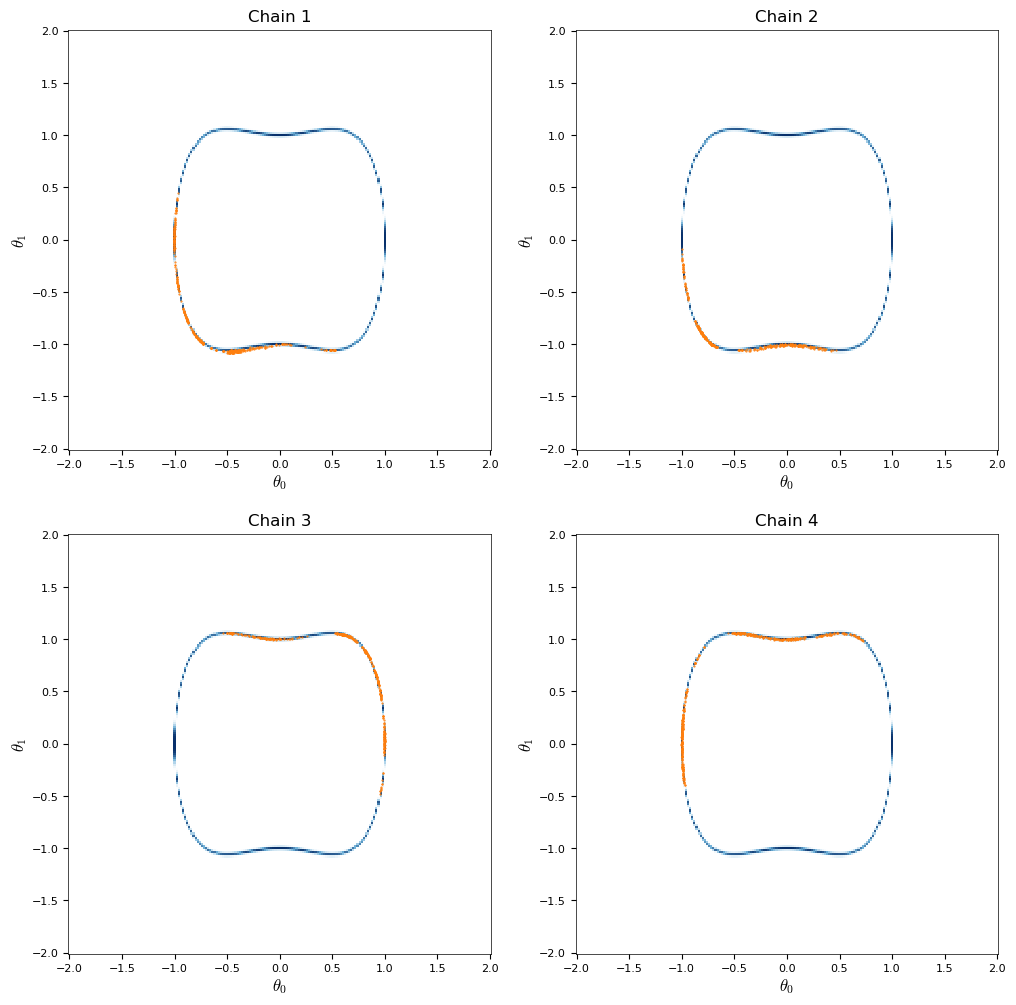

In [41]:
def sample_rmhmc_chains(σ, y, ϵ, n_chain, n_iter):
    system = mici.systems.DenseRiemannianMetricSystem(
        neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
        grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y),
        metric_func=partial(metric, σ=σ),
        vjp_metric_func=partial(vjp_metric, σ=σ),
    )
    integrator = mici.integrators.ImplicitLeapfrogIntegrator(system, step_size=ϵ)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    θ_inits = np.concatenate(solve_for_limiting_manifold(y, n_chain))
    start_time = time.time()
    final_states, traces, stats = sampler.sample_chains(
        n_warm_up_iter=0,
        n_main_iter=n_iter,
        init_states=θ_inits,
        n_process=n_chain,
        monitor_stats=["accept_stat", "convergence_error"],
    )
    run_time = time.time() - start_time
    return traces, run_time


rmhmc_traces, rmhmc_run_time = sample_rmhmc_chains(σ, y, 0.3 * σ, n_chain, 500)
print_rhat_and_time_normalised_ess(rmhmc_traces, rmhmc_run_time)
fig, axes = plot_traces(rmhmc_traces, σ, y)

### Constrained Hamiltonian Monte Carlo on lifted on distribution

For the constrained HMC method we run four chains of 1000 iterations using a step size of $\epsilon = 0.1$ which was previously found to give reasonable acceptance rates for all $\sigma$.

Sampling stage: Main non-adaptive [00:57]

Chain 1/4: 100%|██████████|1000/1000 [00:56<00:00, 17.59it/s, accept_stat=0.996, convergence_error=0.00]

Chain 2/4: 100%|██████████|1000/1000 [00:57<00:00, 17.53it/s, accept_stat=0.996, convergence_error=0.00]

Chain 3/4: 100%|██████████|1000/1000 [00:57<00:00, 17.32it/s, accept_stat=0.995, convergence_error=0.00]

Chain 4/4: 100%|██████████|1000/1000 [00:57<00:00, 17.43it/s, accept_stat=0.995, convergence_error=0.00]

θ[0]: estimated R̂ = 1.00 and effective samples per run time = 54.9 s⁻¹
θ[1]: estimated R̂ = 1.02 and effective samples per run time = 7.36 s⁻¹


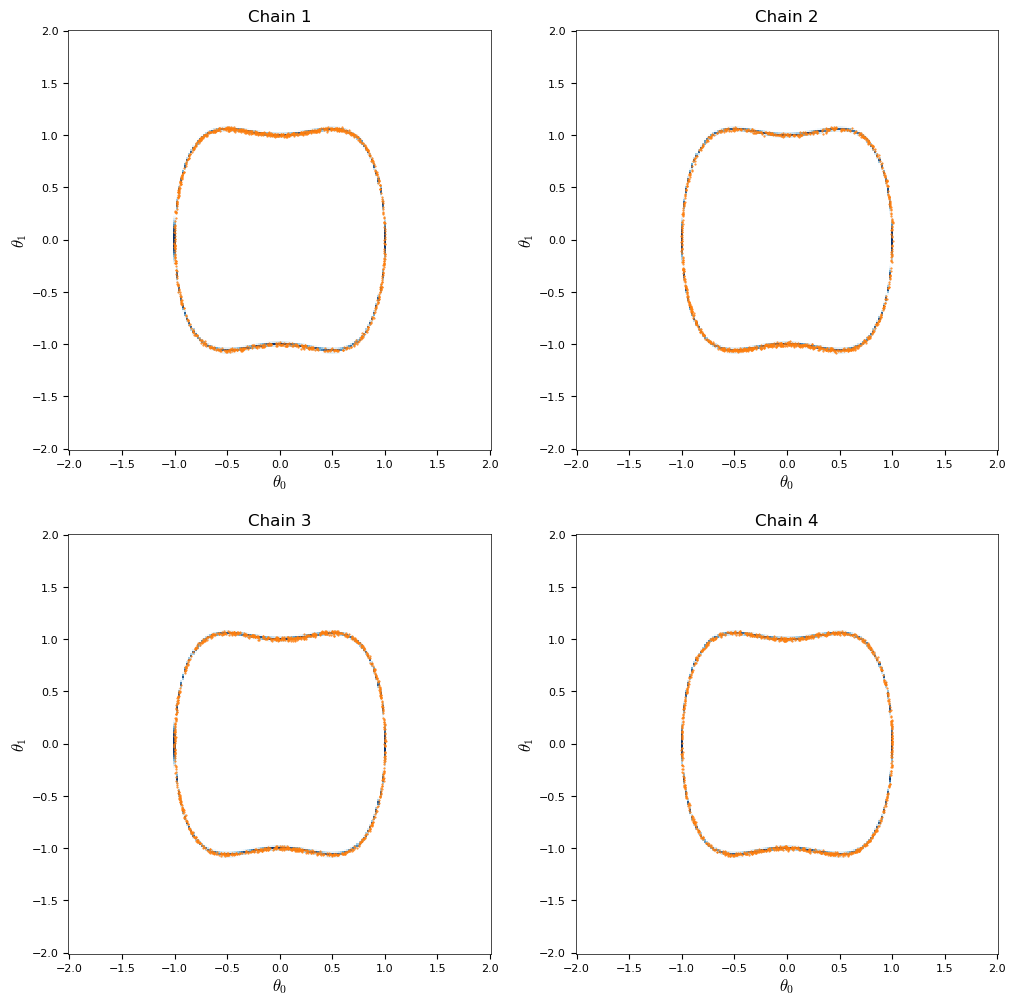

In [42]:
def sample_chmc_chains(σ, y, ϵ, n_chain, n_iter):
    system = mici.systems.DenseConstrainedEuclideanMetricSystem(
        neg_log_dens=neg_log_prior_dens,
        grad_neg_log_dens=grad_neg_log_prior_dens,
        dens_wrt_hausdorff=False,
        constr=partial(constr, σ=σ, y=y),
        jacob_constr=partial(jacob_constr, σ=σ, y=y),
        mhp_constr=partial(mhp_constr, σ=σ, y=y),
    )
    integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
        system,
        step_size=ϵ,
        projection_solver=mici.solvers.solve_projection_onto_manifold_newton,
    )
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    q_inits = [
        np.concatenate([θ, (y - forward_func(θ)) / σ])
        for θ in np.concatenate(solve_for_limiting_manifold(y, n_chain))
    ]
    start_time = time.time()
    final_states, traces, stats = sampler.sample_chains(
        n_warm_up_iter=0,
        n_main_iter=n_iter,
        init_states=q_inits,
        n_process=n_chain,
        monitor_stats=["accept_stat", "convergence_error"],
    )
    run_time = time.time() - start_time
    return traces, run_time


chmc_traces, chmc_run_time = sample_chmc_chains(σ, y, 0.1, n_chain, 1000)
print_rhat_and_time_normalised_ess(chmc_traces, chmc_run_time)
fig, axes = plot_traces(chmc_traces, σ, y)

## Conclusion

From both the trace plots and $\hat{R}$ convergence diagnostic values (for which values more than one indicate poorly converged chains) we see that despite having the longest run time by far the Riemannian-manifold chains have not yet converged to stationarity, with each chain having explored only a small portion of the region of high posterior probability. Both the Euclidean and constrained HMC chains appear to have mixed better, however we see from the time normalised effective sample size estimates that the constrained HMC method is the more computationally efficient, despite the much higher cost of the constrained leapfrog integrator. While the relative performances of the Euclidean and Riemannian-manifold HMC methods would improve for larger $\sigma$ our interest is not in performance at a particular $\sigma$ but rather in illustrating that the proposed constrained HMC approach remains efficient for small $\sigma$ unlike the other two HMC methods and so will always eventually dominate in sampling efficiency for small enough $\sigma$.

In the paper we provide additional experimental results illustrating that similar efficiency gains are also seen in more realistic inference problems: inferring the parameters of an ODE model given noisy observations of at a sequence of time points and a partial differential equation Bayesian inverse problem where the task is to infer a coefficient field give noisy observations of the solution field at a set of points. In both cases we see that while in existing MCMC methods such as HMC the sampling efficiency decreases as the observation noise becomes smaller and the observations more informative, the proposed constrained HMC approach remains efficient.

## References

  1. Au, K. X., Graham, M. M., & Thiery, A. H. (2023). Manifold lifting: scaling Markov chain Monte Carlo to the vanishing noise regime. Journal of the Royal Society: Series B (Statistical Methodology), 85(3), 757-782.
  2. Betancourt, M. (2017). A conceptual introduction to Hamiltonian Monte Carlo. arXiv preprint arXiv:1701.02434.
  3. Duane, S., Kennedy, A. D., Pendleton, B. J., & Roweth, D. (1987). Hybrid Monte Carlo. Physics letters B, 195(2), 216-222.
  4. Girolami, M., & Calderhead, B. (2011). Riemann manifold Langevin and Hamiltonian Monte Carlo methods. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 73(2), 123-214.
  5. Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. Journal of Machine Learning Research, 15(1), 1593-1623.
  6. Lelièvre, T., Rousset, M., & Stoltz, G. (2019). Hybrid Monte Carlo methods for sampling probability measures on submanifolds. Numerische Mathematik, 143(2), 379-421.
  7. Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P. C. (2019). Rank-normalization, folding, and localization: An improved $\widehat{R}$ for assessing convergence of MCMC. arXiv preprint arXiv:1903.08008.
  